<a href="https://colab.research.google.com/github/nbalatamu/Hybrid-Dynamic-Models-for-Species-Dynamics/blob/main/GLV_Data_Generation_for_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from tqdm.notebook import tqdm
import time

%matplotlib inline

We will use this notebook to generate data for simulation purpose. We want to investigate two aspects here:

1. Ability of GLV model with data-driven components to capture changining environmental conditions and high-order interactions.

2. Reproducibility of the model parameters.

For this, we will generate data for 20 models with their own environmental conditions (variables) and model parameters.

For each model, we will generate 200 time points with 100 species.

#Define Model

In [ ]:
class Quadratic(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Quadratic, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        # Initialize the weight tensor B with shape (output_dim, input_dim, input_dim)
        self.B = nn.Parameter(torch.randn(output_dim, input_dim, input_dim))

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        batch_size = x.size(0)
        y_out = torch.zeros(batch_size, self.output_dim, device=x.device)
        for i in range(self.output_dim):
            y_out[:, i] = torch.sum(x.unsqueeze(1) * x.unsqueeze(2) * self.B[i], dim=(1, 2))
        return y_out

    def assign_weights(self, weights):
        # weights should have shape (output_dim, input_dim, input_dim)
        with torch.no_grad():
            self.B.copy_(weights)

In [ ]:
class CombinedODEModel(nn.Module):
    def __init__(self, n, m):
        super(CombinedODEModel, self).__init__()
        self.n = n
        self.m = m

        self.net_1 = nn.Linear(n, m)

        self.net_2 = nn.Linear(m, m, bias = False)

        self.net_3 = Quadratic(m, m)

        self.e = None  # Placeholder for control variables

    def set_control_variables(self, e):
        self.e = e

    def forward(self, t, x):
        e_t = self.e[int(t.item()-1), :, :]  # Get the control variables at the current time step for all batches # subtract 1 to account for batch_t starting from index 1

        return x*(self.net_1(e_t) + self.net_2(x) + self.net_3(x))

#Generate Environmental Variables and get Model Parameters

In [ ]:
def generate_env_time_series(n, T):
    """
    Generate n discrete time series each with T time points.

    Parameters:
    n (int): Number of time series
    T (int): Number of time points

    Returns:
    np.ndarray: Array of shape (n, T) containing the generated sine curves
    """
    # Generate time points
    t = np.linspace(1, T, T)

    # Initialize the array to store the time series
    env_time_series = np.zeros((n, T))

    for i in range(n):
        # Randomly choose A, omega, and phi
        A = np.random.uniform(1.0, 5.0)  # Amplitude between 0.5 and 2.0
        omega = np.random.uniform(0.01, 0.04)  # Frequency between 0.5 and 2.0
        phi = np.random.uniform(0, 2 * np.pi)  # Phase shift between 0 and 2*pi

        # Generate the sine curve
        env_time_series[i] = A * np.sin(omega * t + phi)

    return env_time_series

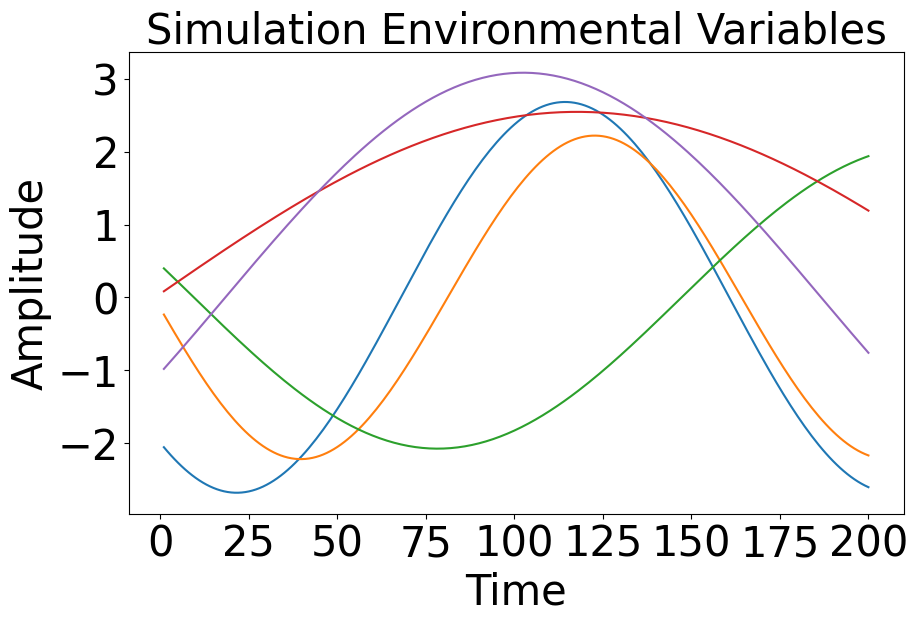

In [ ]:
# Example usage
n = 5
T = 200
time_series = generate_env_time_series(n, T)

# Plot the generated time series
t = np.linspace(1, T, T)

plt.figure(figsize=(10, 6))
for i in range(n):
    plt.plot(t, time_series[i], label=f'Env Var {i+1}')

plt.title('Simulation Environmental Variables', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.legend()
plt.grid(False)
plt.show()

In [ ]:
def normalize_time_series(time_series):
    """
    Normalize the time series by subtracting the mean and dividing by the standard deviation.

    Parameters:
    time_series (np.ndarray): Array of shape (n, T) containing the generated sine curves

    Returns:
    np.ndarray: Array of shape (n, T) containing the normalized time series
    """
    n, T = time_series.shape
    normalized_time_series = np.zeros((n, T))

    for i in range(n):
        mean = np.mean(time_series[i])
        std_dev = np.std(time_series[i])

        # Normalize the time series
        normalized_time_series[i] = (time_series[i] - mean) / std_dev

    return normalized_time_series

In [ ]:
# Example usage
normalized_time_series = normalize_time_series(time_series)

# Print the shape to confirm
print(normalized_time_series.shape)  # Should print (n, T)

# Plot the normalized time series
plt.figure(figsize=(10, 6))
for i in range(n):
    plt.plot(t, normalized_time_series[i], label=f'Normalized Series {i+1}')

plt.title('Normalized Sine Curves')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(False)
plt.show()

NameError: name 'normalize_time_series' is not defined

#Get Data

Define a dictionary that contains:

1. Environmental variables
2. Model parameters
3. Initial conditions
4. Species evolution

Get 20 such dictionary elements.

#Define Model

In [ ]:
def euler(func, t, dt, y, e):
  return dt * func(t, y, e)

In [ ]:
# Neural ODE model
class NeuralODE(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, y0, e, t, solver):

    solution = torch.empty(len(t), *y0.shape, dtype=y0.dtype, device=y0.device)
    solution[0] = y0

    j = 1
    for t0, t1 in zip(t[:-1], t[1:]):
      dy = solver(self.func, t0, t1 - t0, y0, e[j-1,:,:])
      y1 = y0 + dy
      solution[j] = y1
      j += 1
      y0 = y1
    return solution

In [ ]:
# define GLV Model
class ODEFunc_sim(nn.Module):
  def __init__(self, n, m):
    super().__init__()
    self.n = n
    self.m = m

    self.net_1 = nn.Linear(n, m)
    self.net_2 = nn.Linear(m, m, bias = False)
    self.net_3 = Quadratic(m, m)

  def forward(self, t, y, e):

    output = y*self.net_1(e) + y*self.net_2(y) + y*self.net_3(y)
    return output

#Get Data

In [ ]:
n = 5    #no of env vars
m = 100  #no of species
T = 200   #no of time points

T_end = 0.4

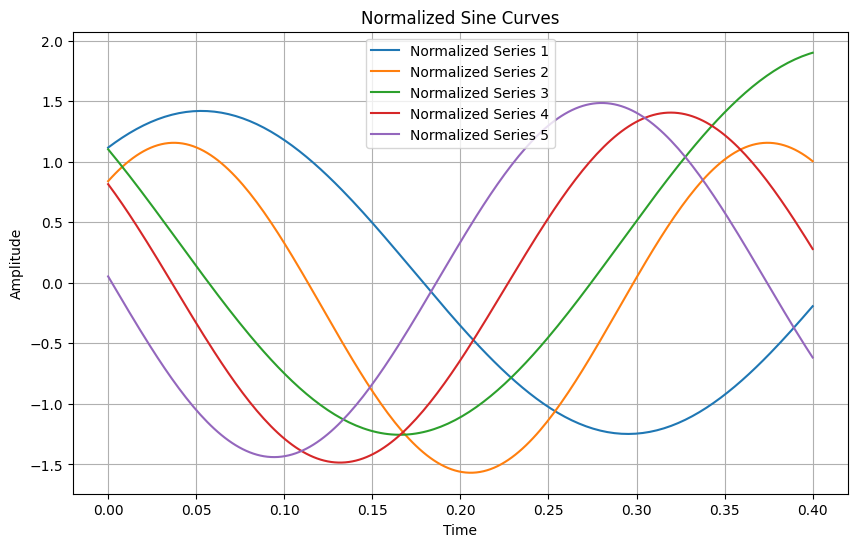

In [ ]:
t = torch.tensor(np.linspace(0, T_end, T))
e = normalize_time_series(generate_env_time_series(n, T))
e = torch.tensor(e, dtype=torch.float32)

# Plot the normalized time series
plt.figure(figsize=(10, 6))
for i in range(n):
    plt.plot(t, e[i], label=f'Normalized Series {i+1}')

plt.title('Normalized Sine Curves')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

sim = NeuralODE(func = ODEFunc_sim(n, m))

#Assign model weights
nn.init.normal_(sim.func.net_1.weight, mean=0, std=0.1)
nn.init.normal_(sim.func.net_1.bias, mean=0, std=0.1)
nn.init.normal_(sim.func.net_2.weight, mean=0, std=0.1)
nn.init.normal_(sim.func.net_3.B, mean=0, std=0.001)

# Ensure diagonal elements of net_2 weight matrix are negative
with torch.no_grad():
    for i in range(m):
        if sim.func.net_2.weight[i, i] > 0:
            sim.func.net_2.weight[i, i] = -sim.func.net_2.weight[i, i]  # Ensure it's negative

In [ ]:
x_0 = torch.rand(m) * 5

with torch.no_grad():
    pred_y = sim(x_0.unsqueeze(0), e.transpose(0, 1).unsqueeze(1), t, solver=euler)

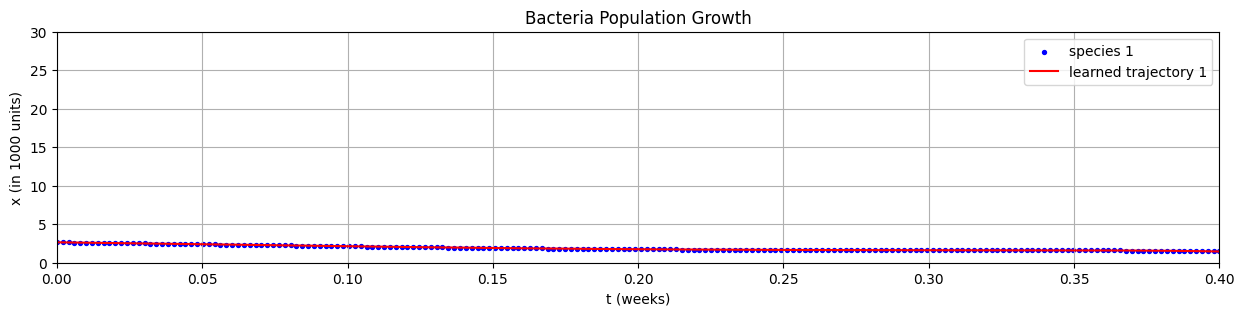

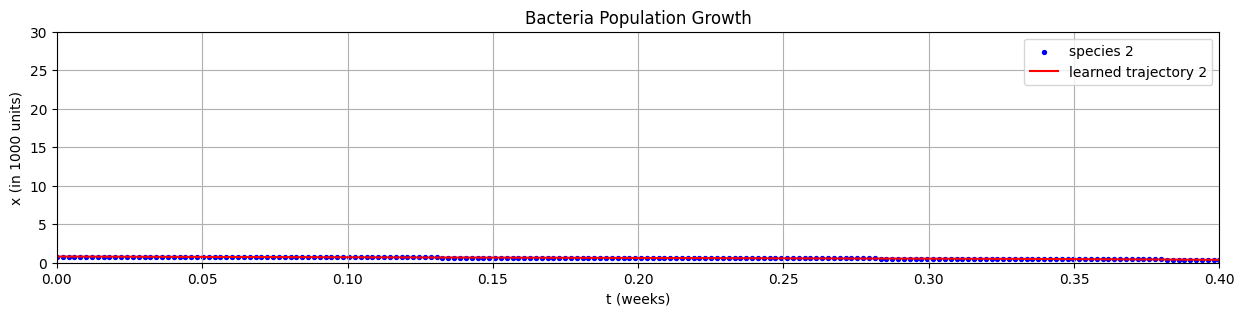

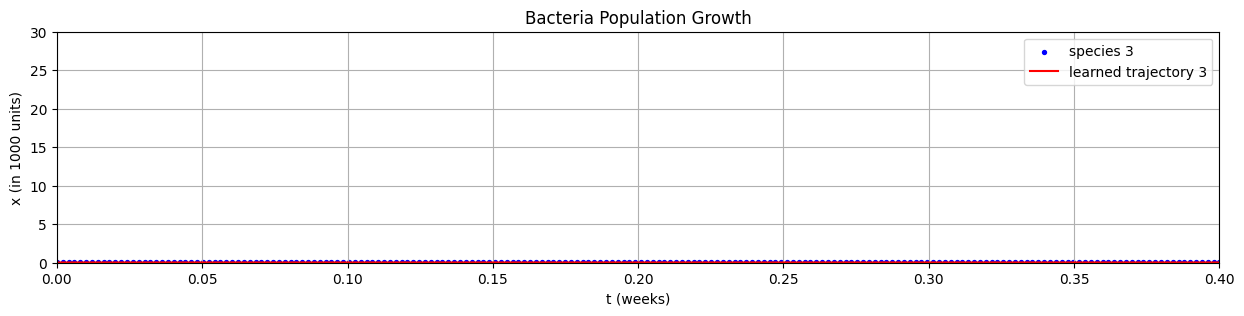

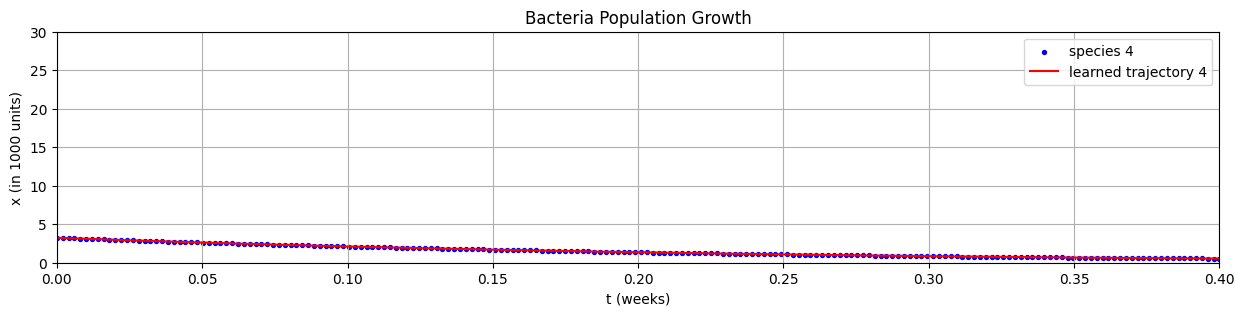

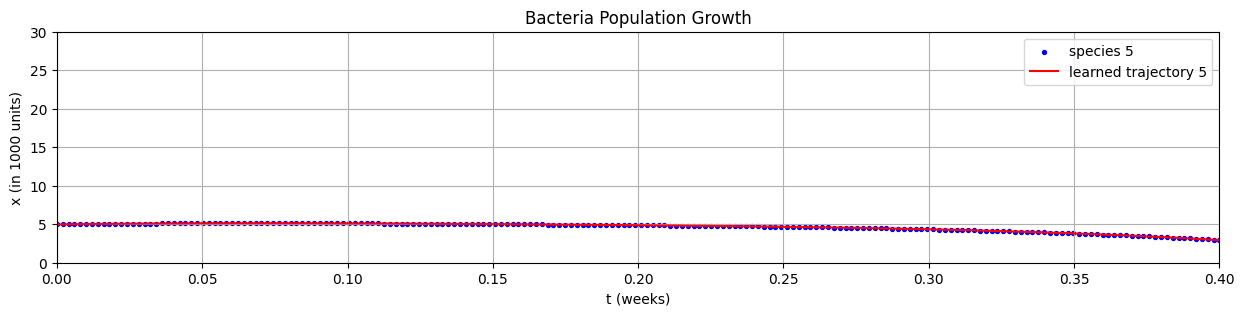

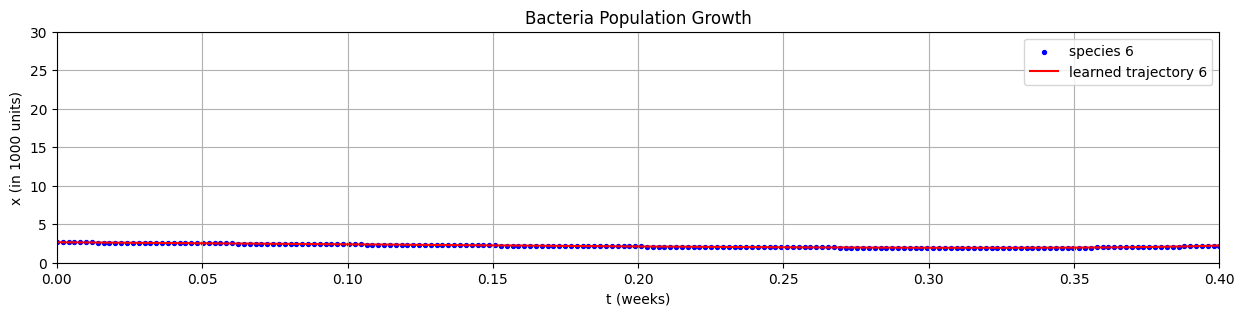

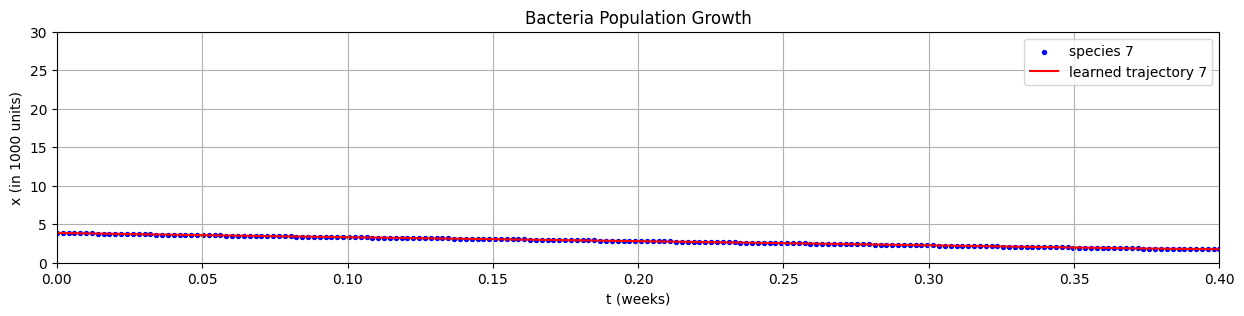

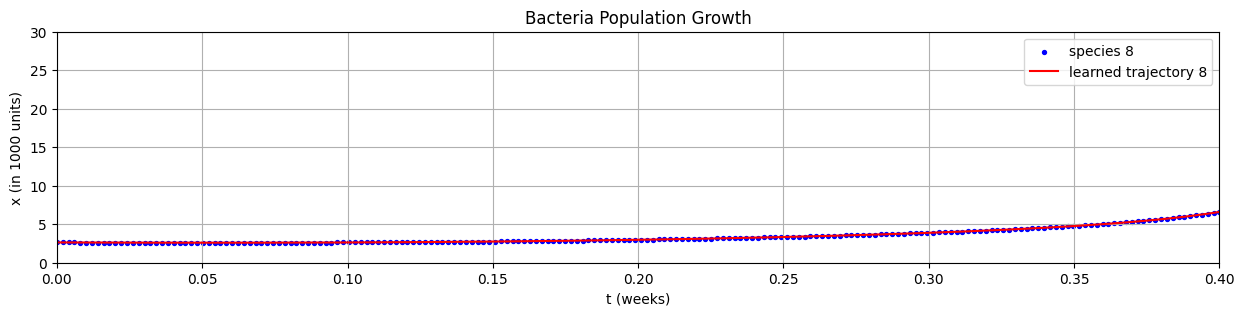

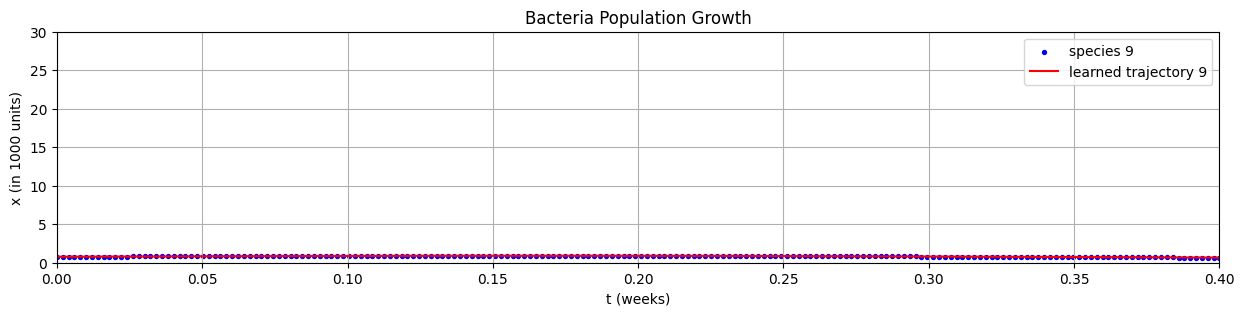

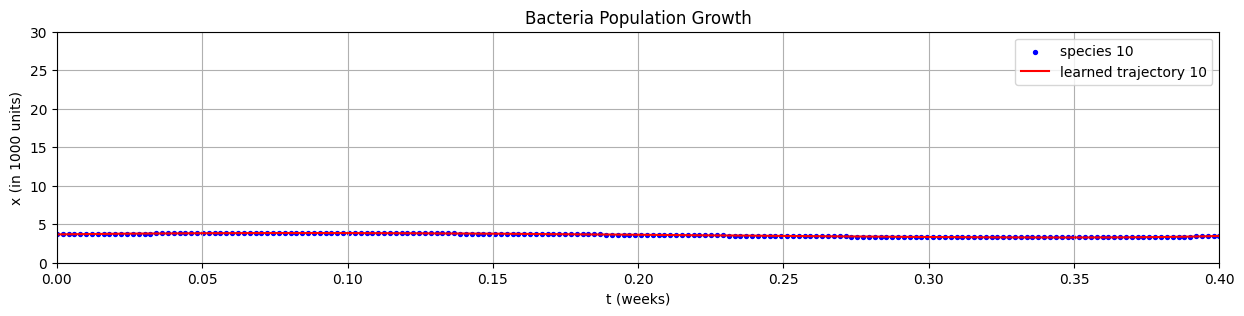

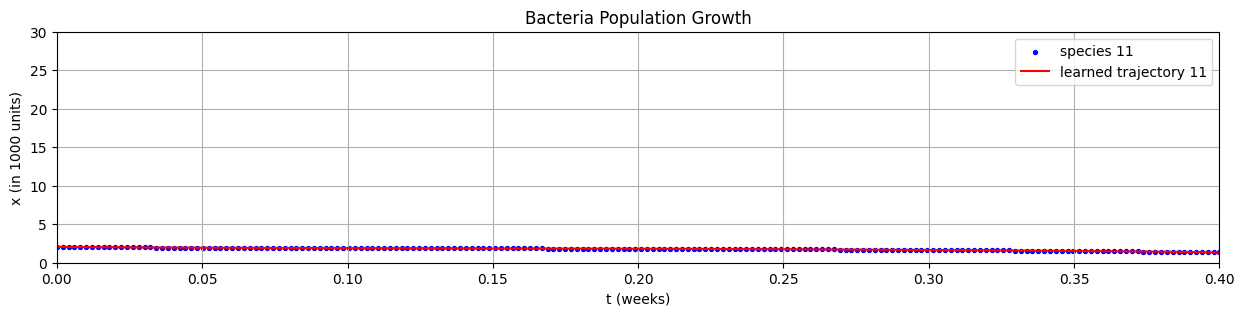

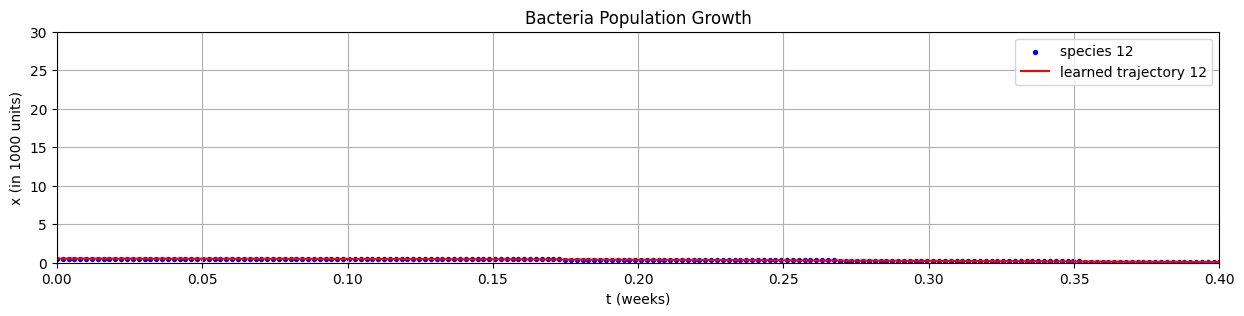

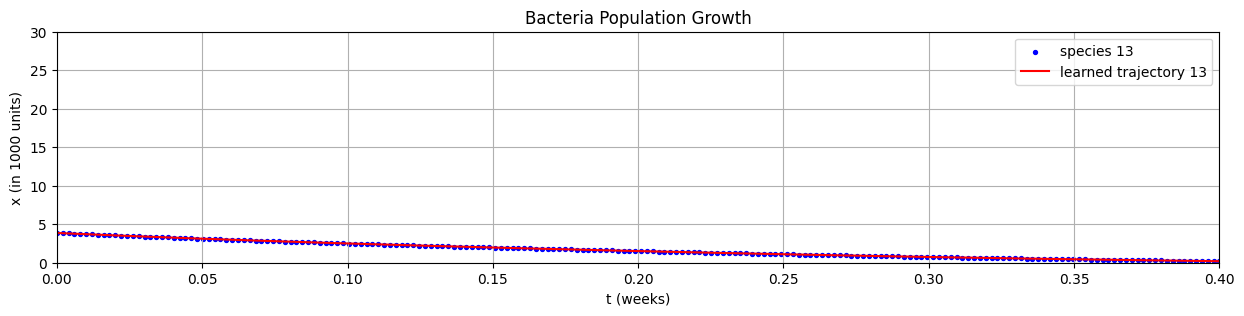

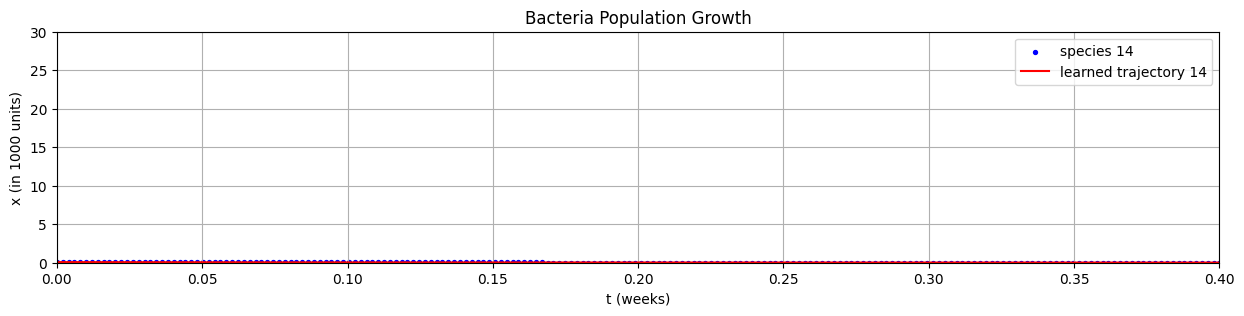

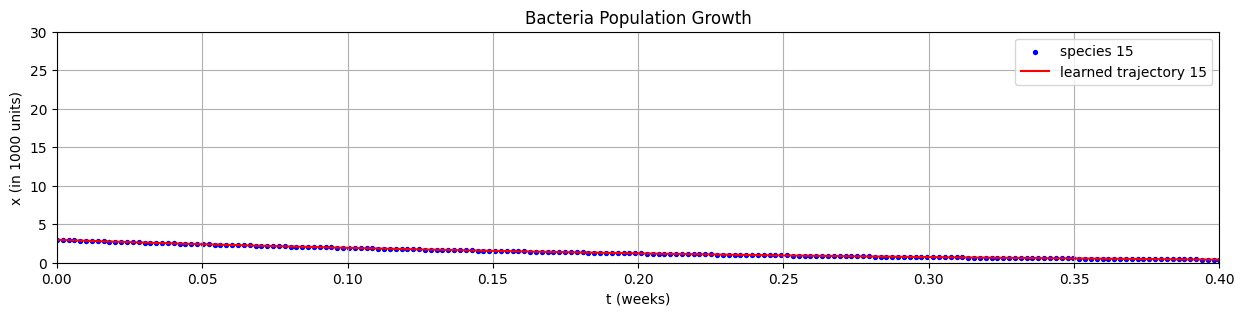

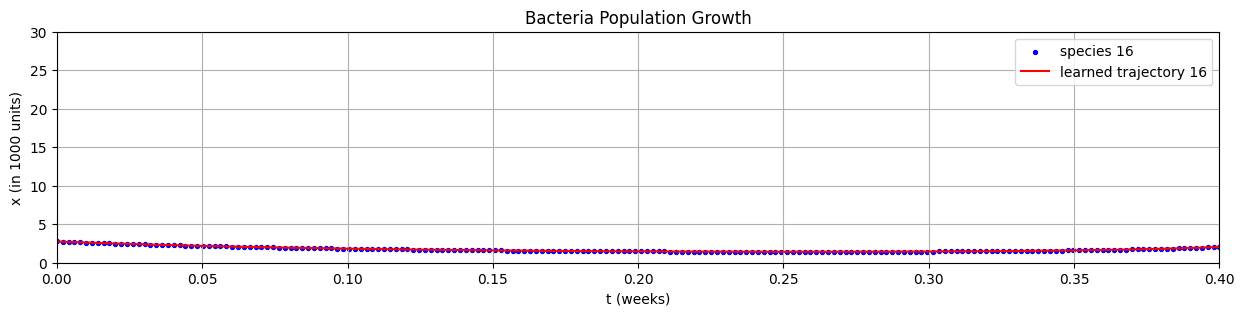

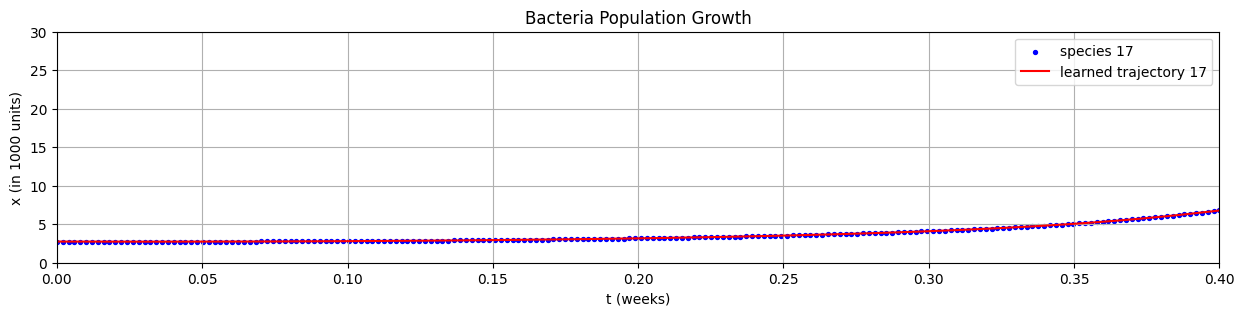

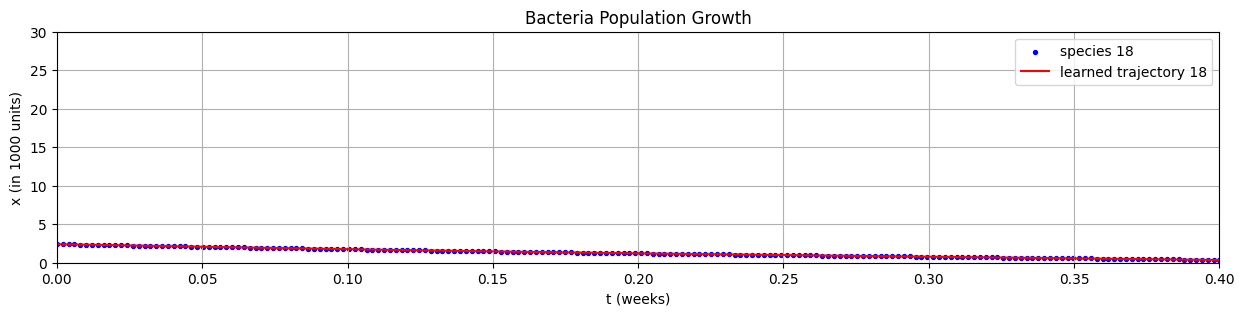

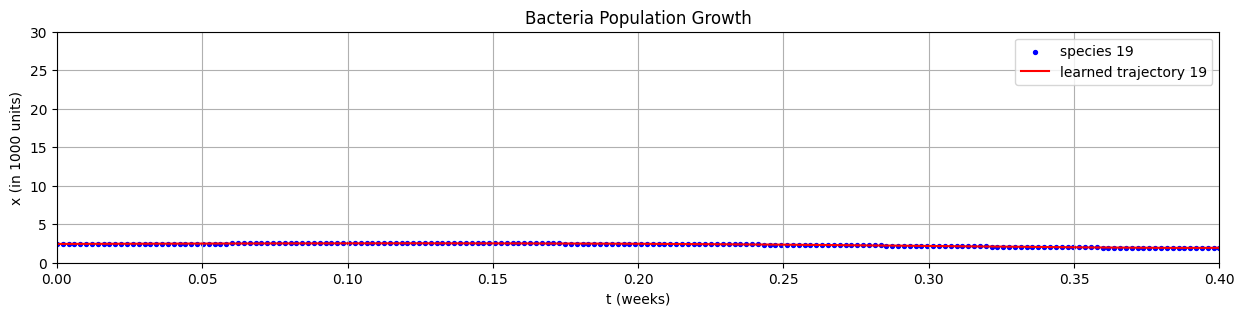

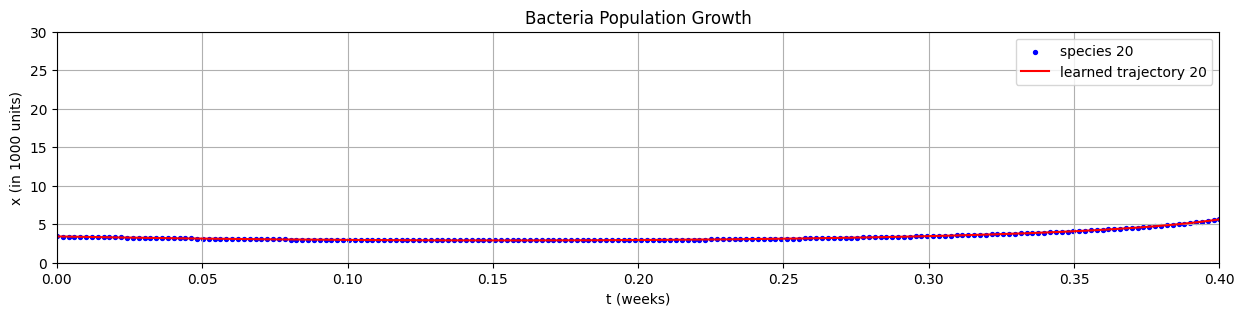

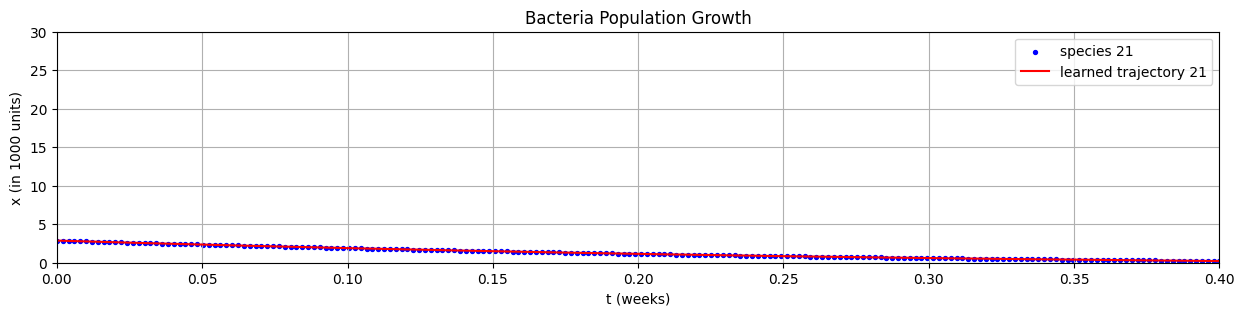

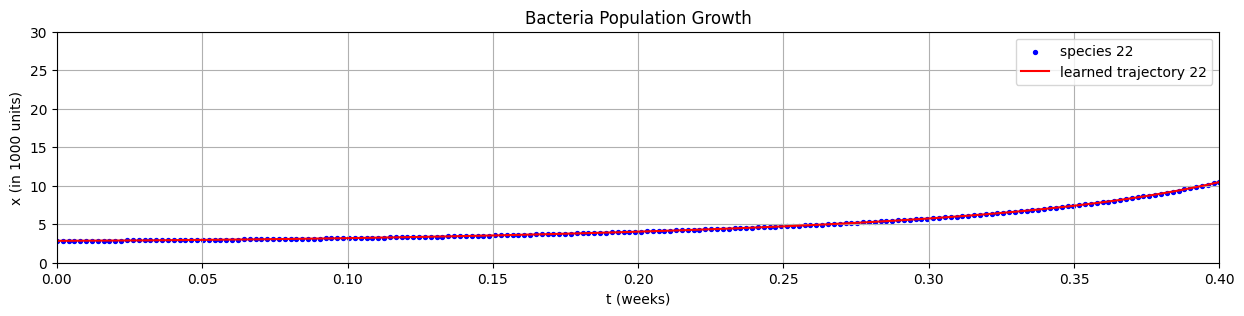

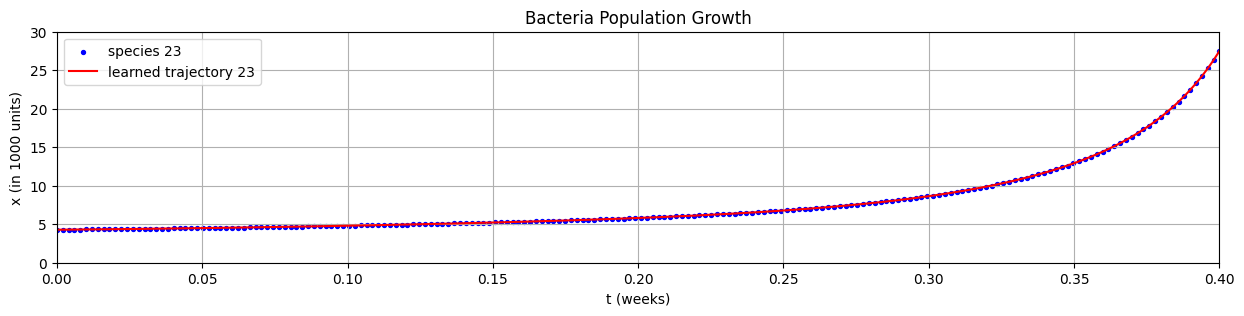

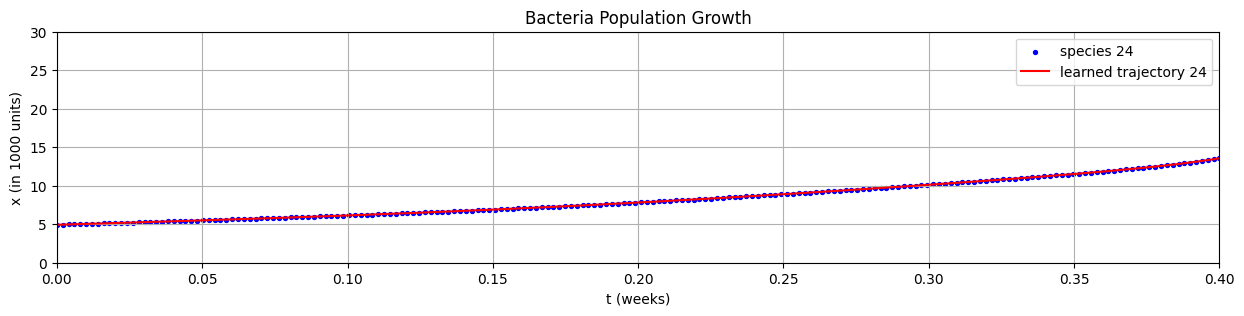

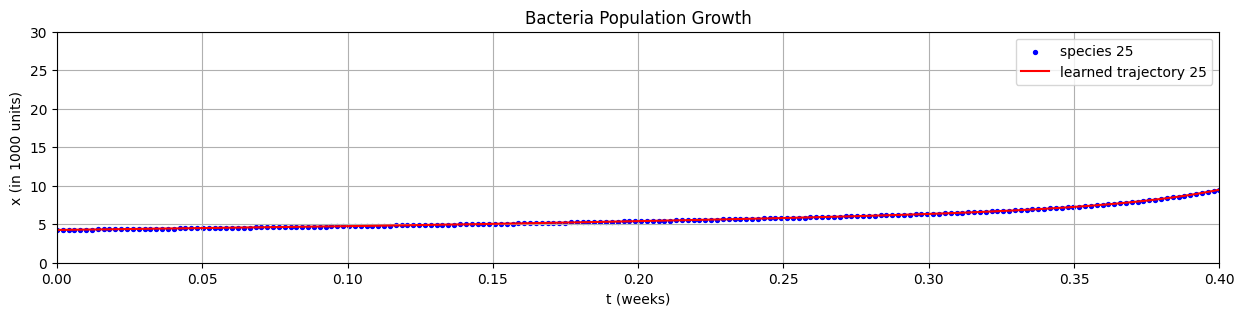

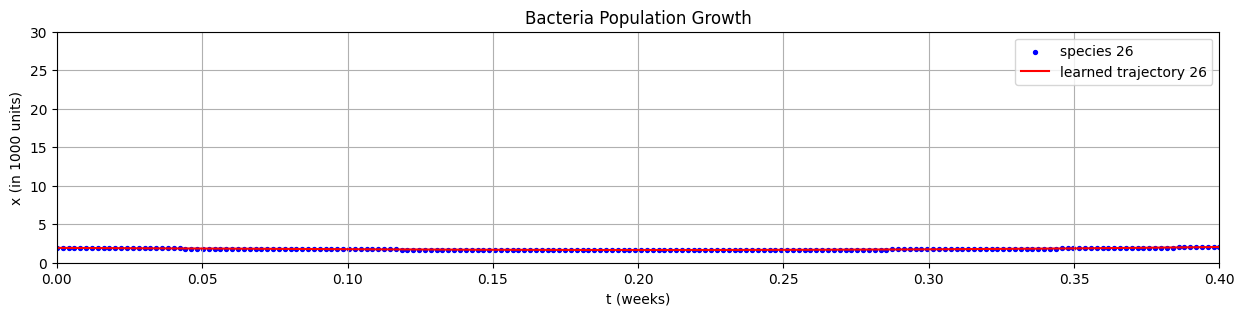

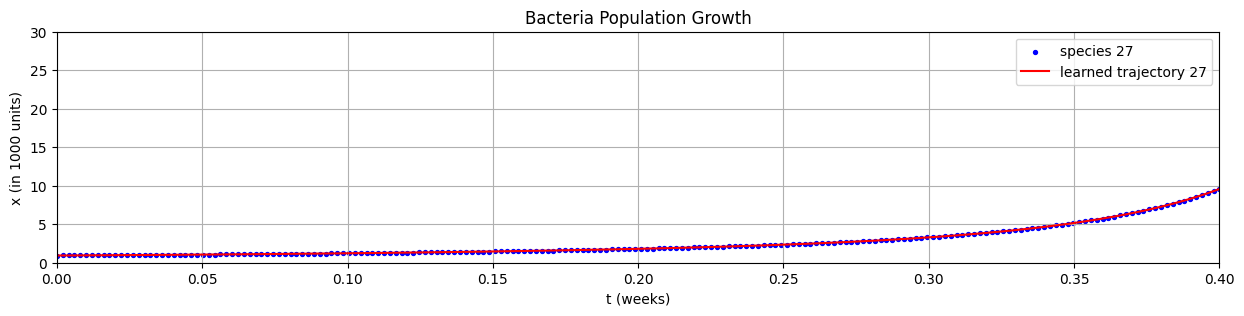

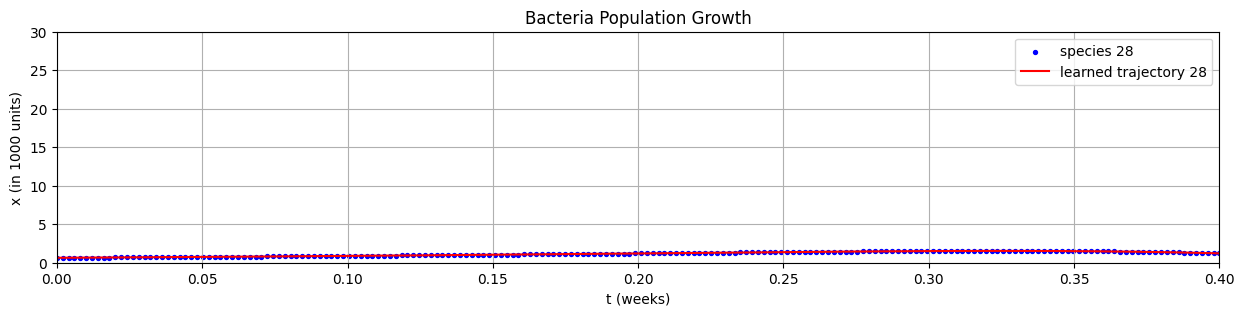

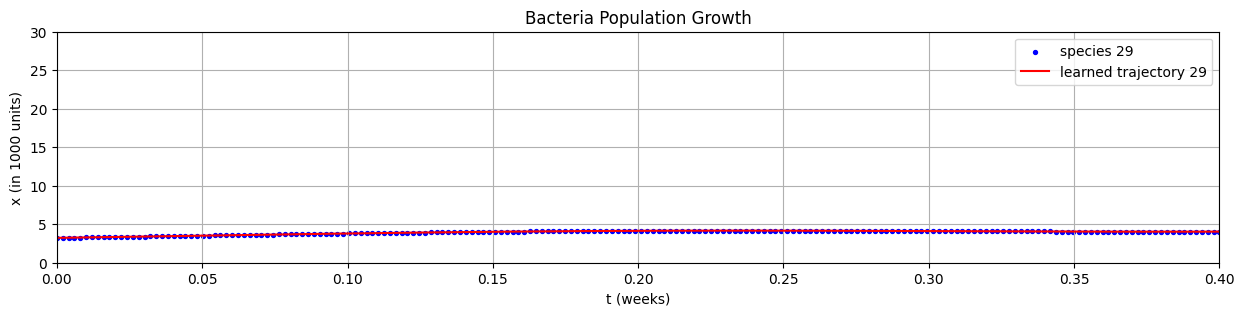

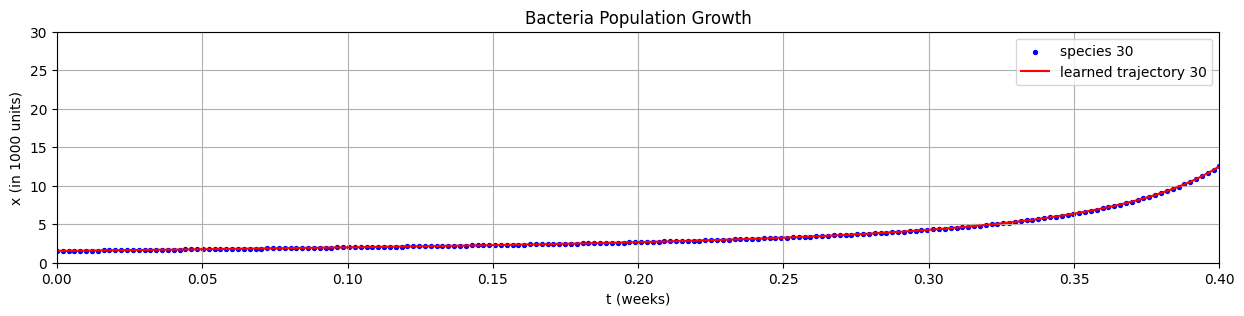

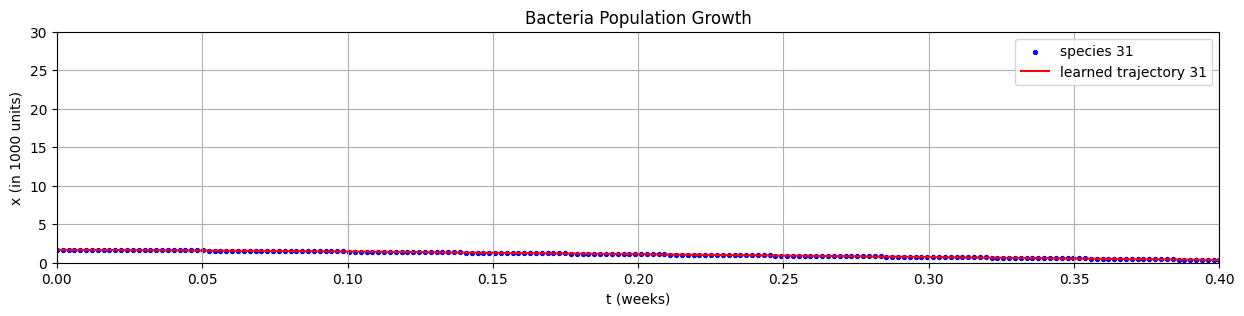

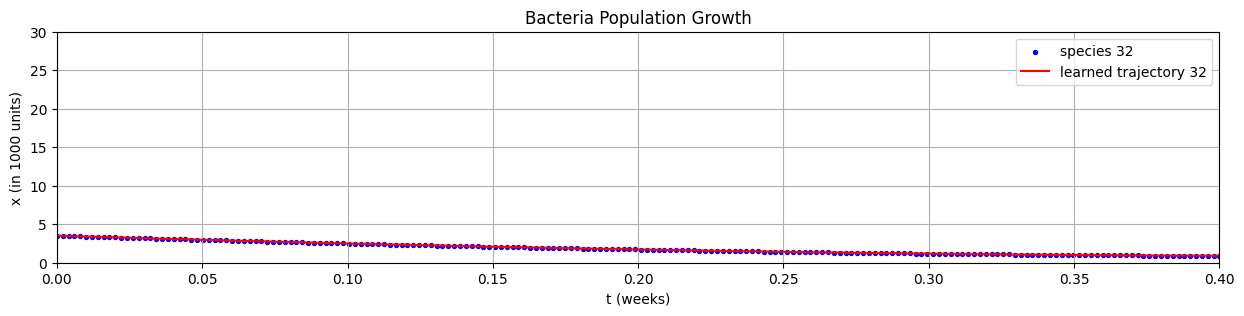

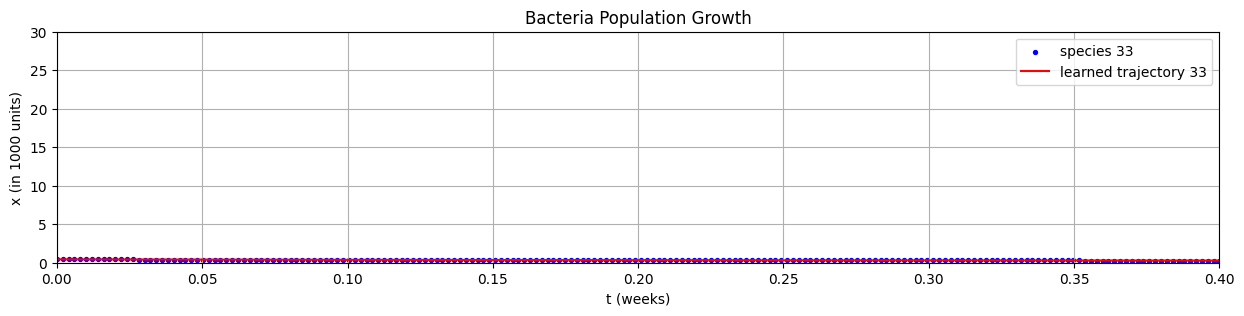

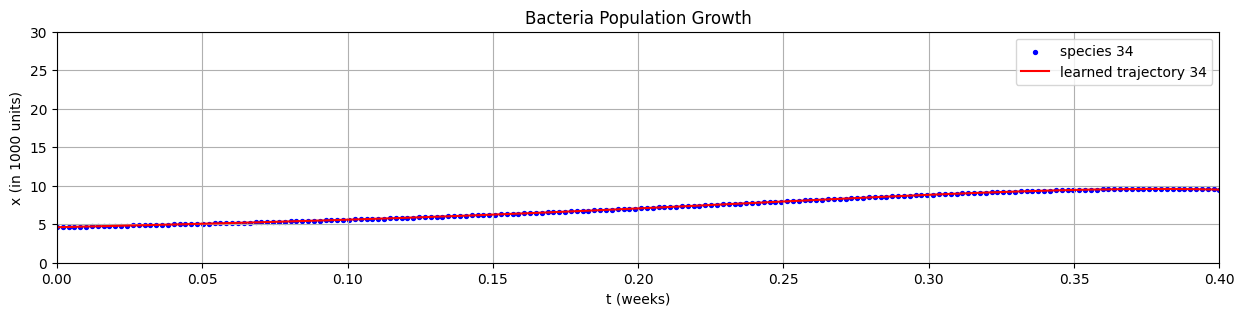

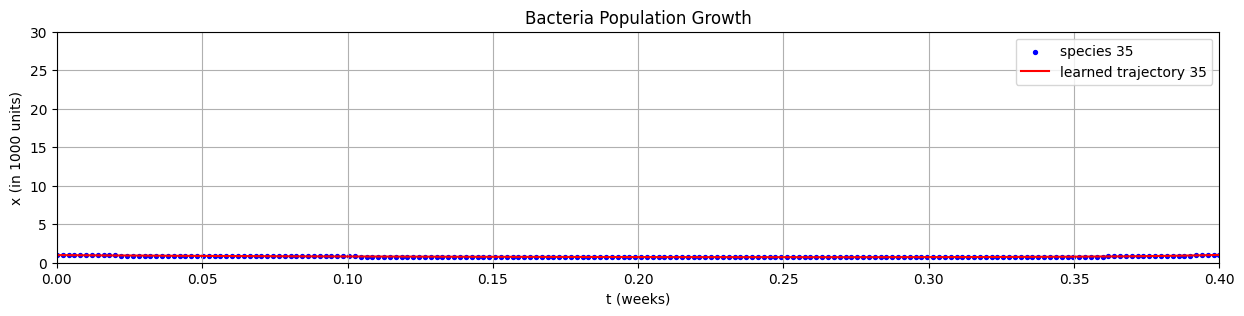

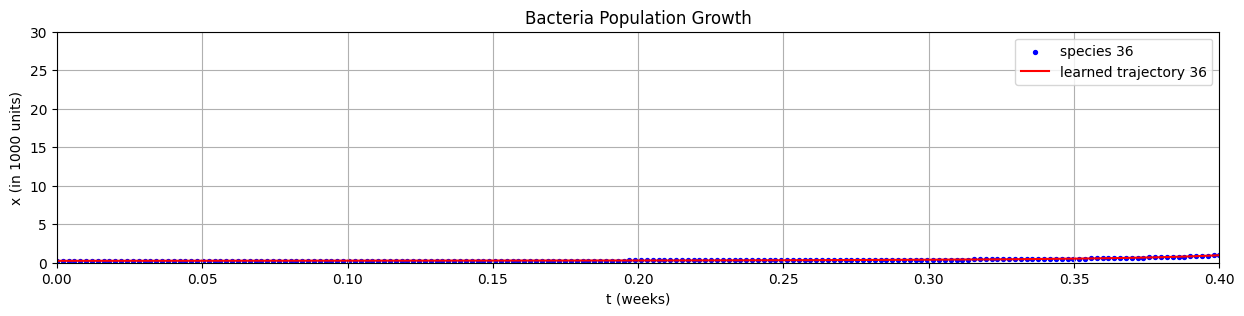

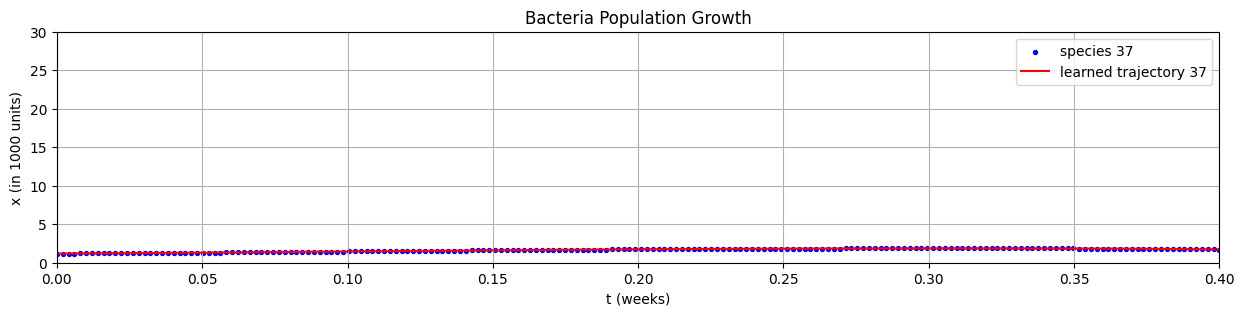

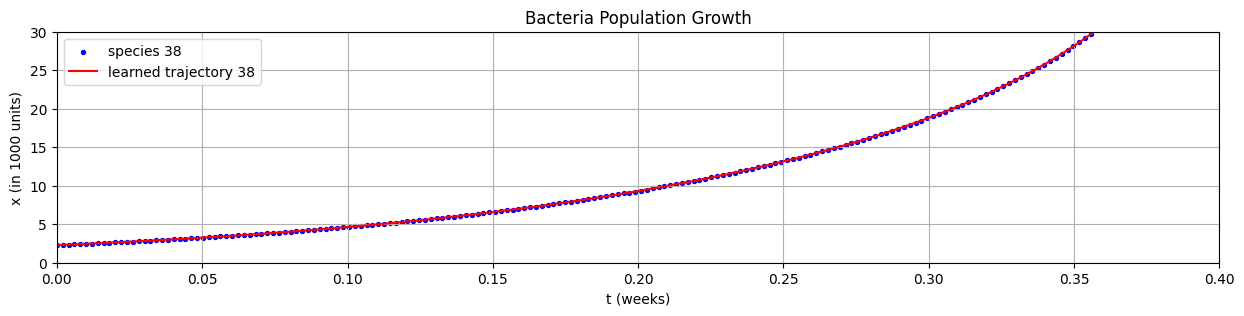

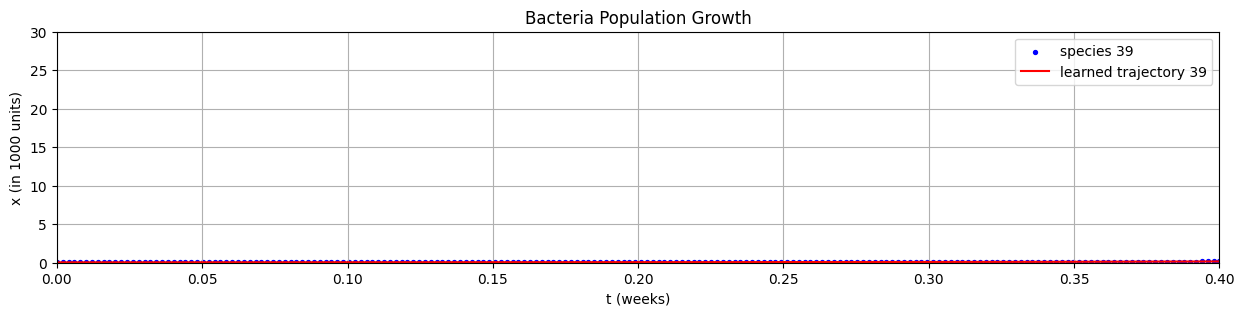

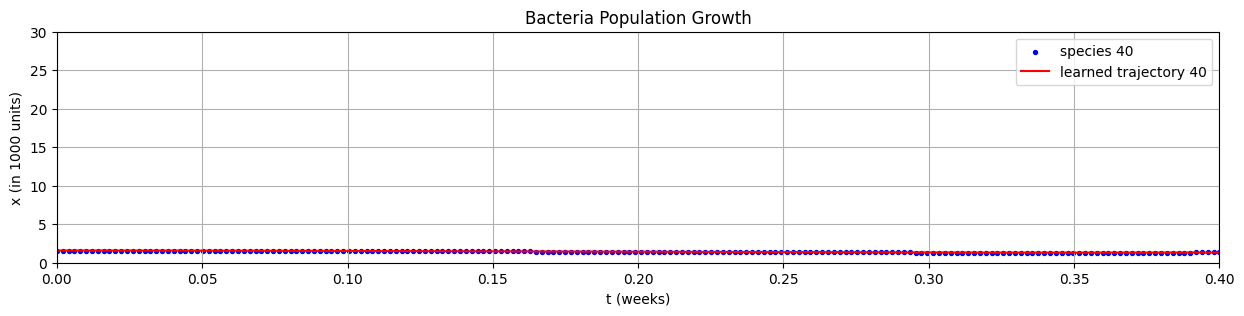

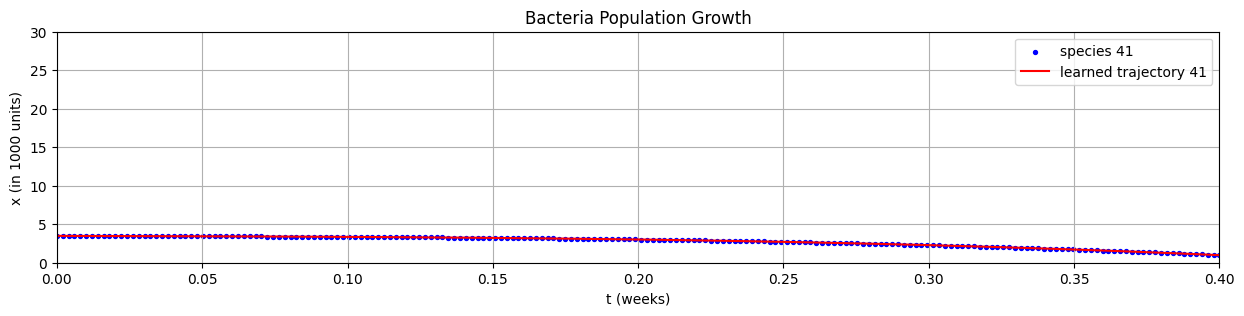

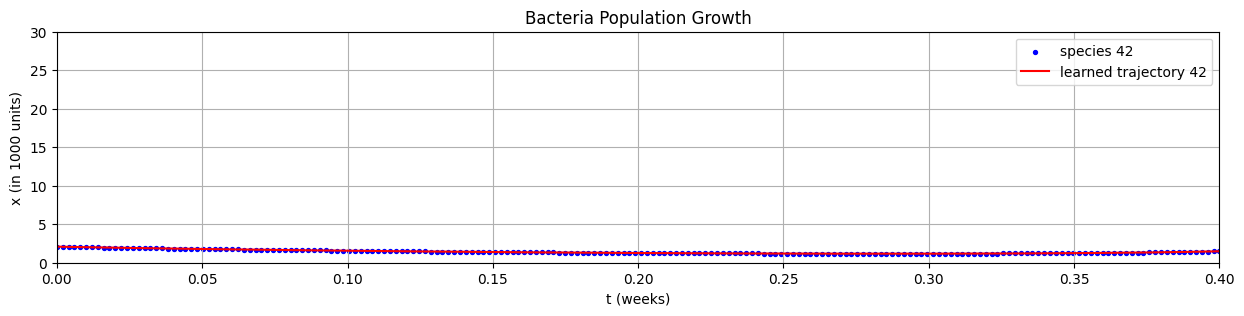

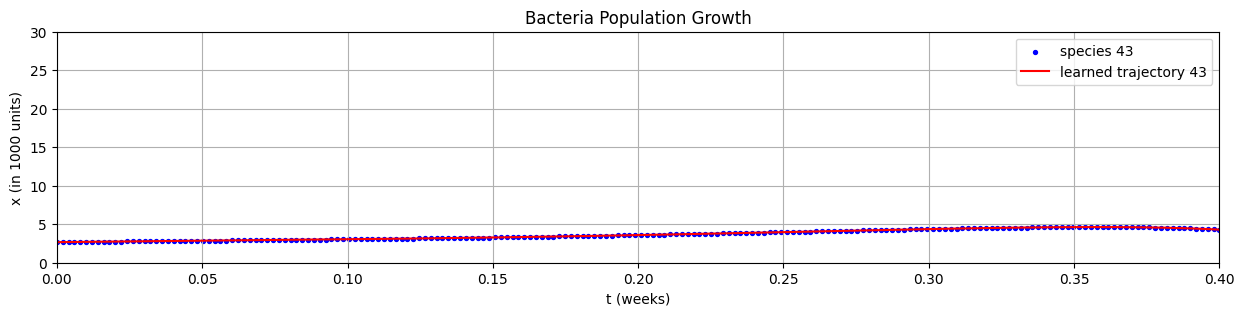

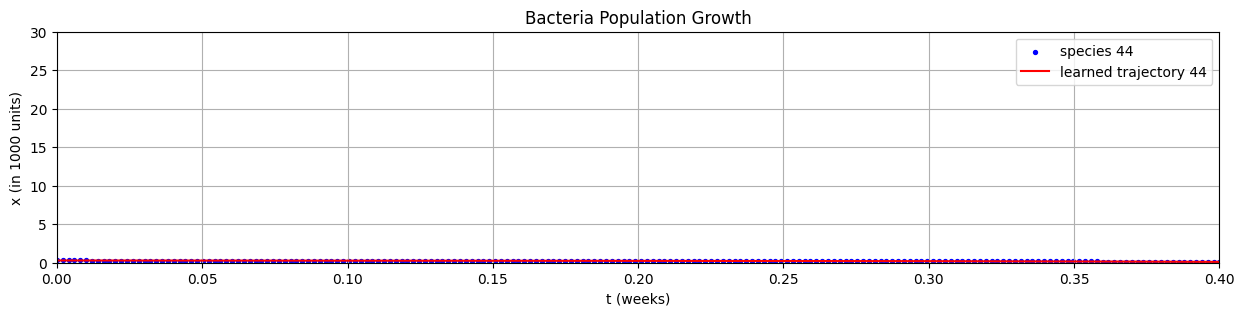

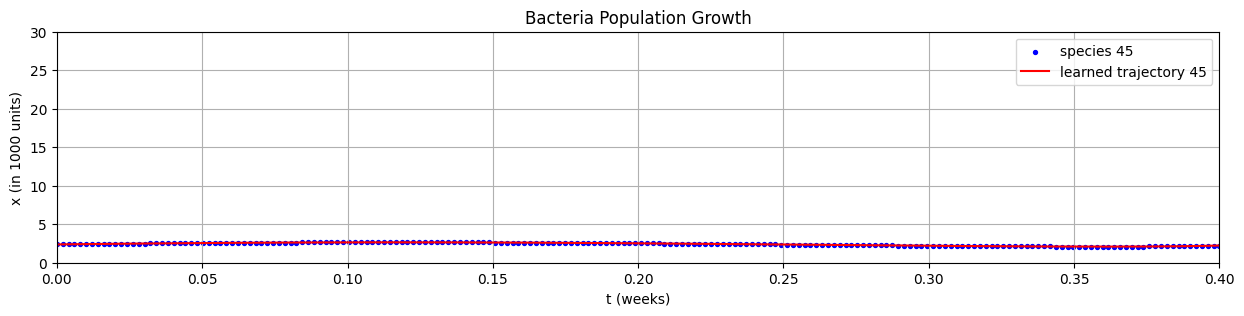

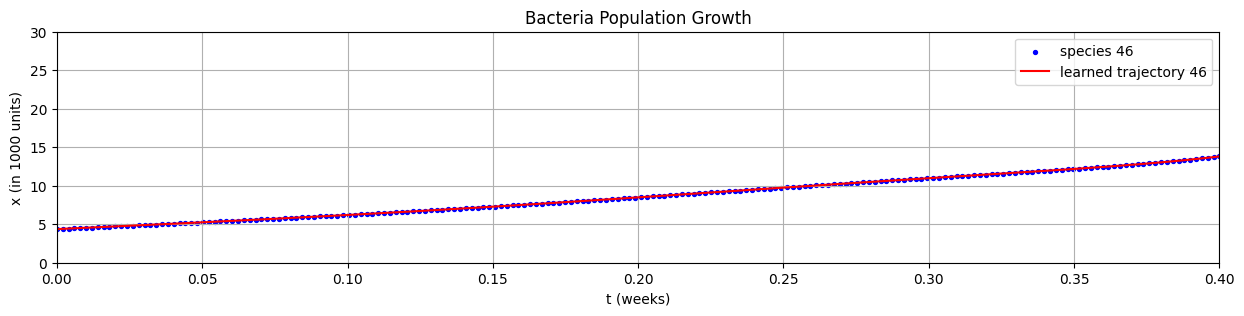

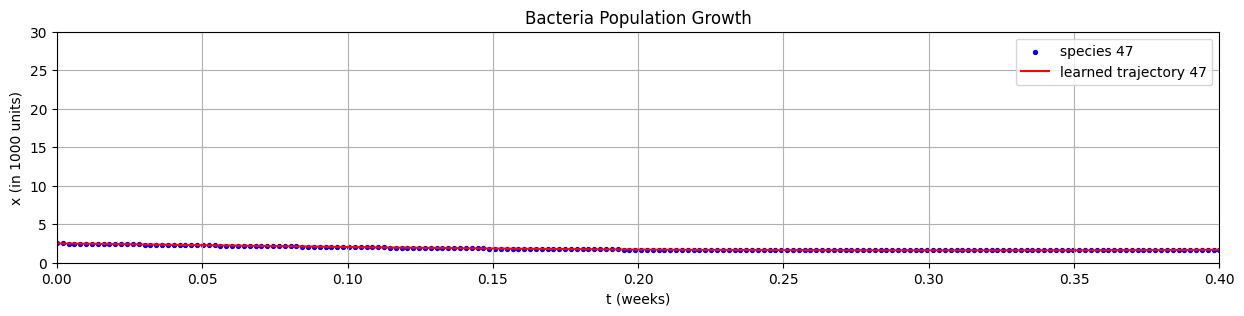

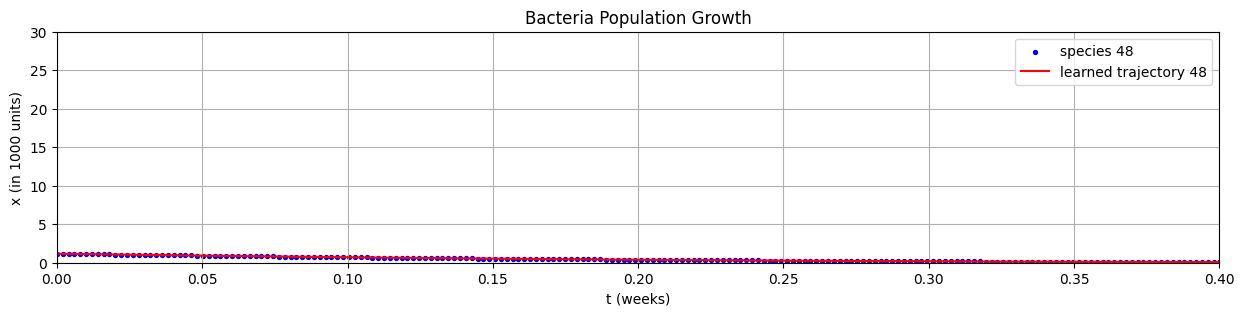

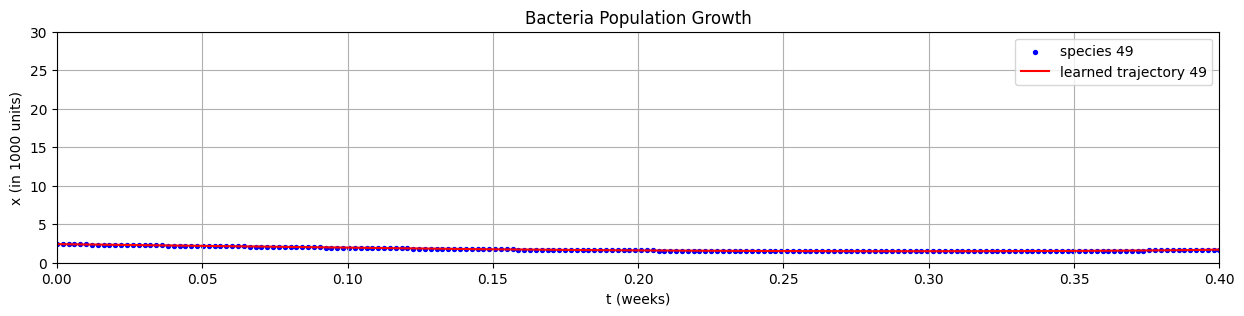

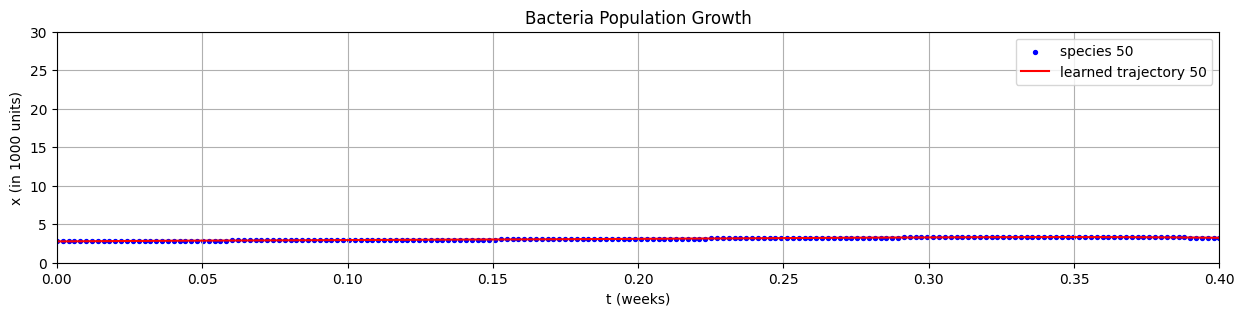

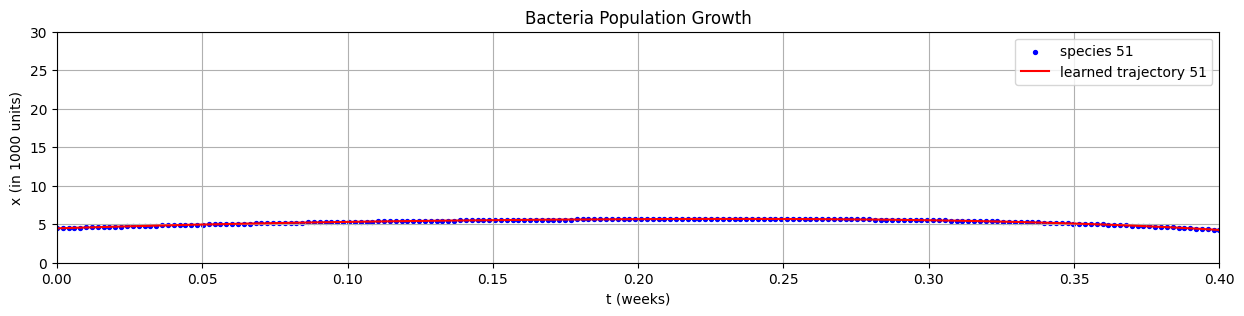

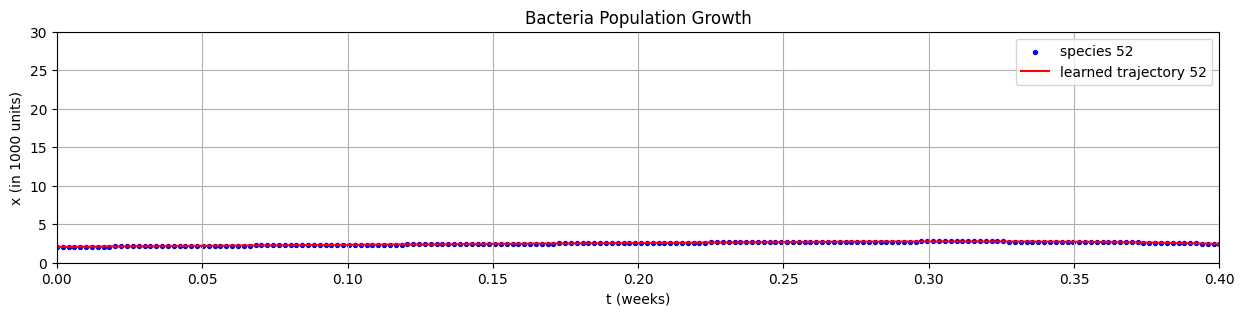

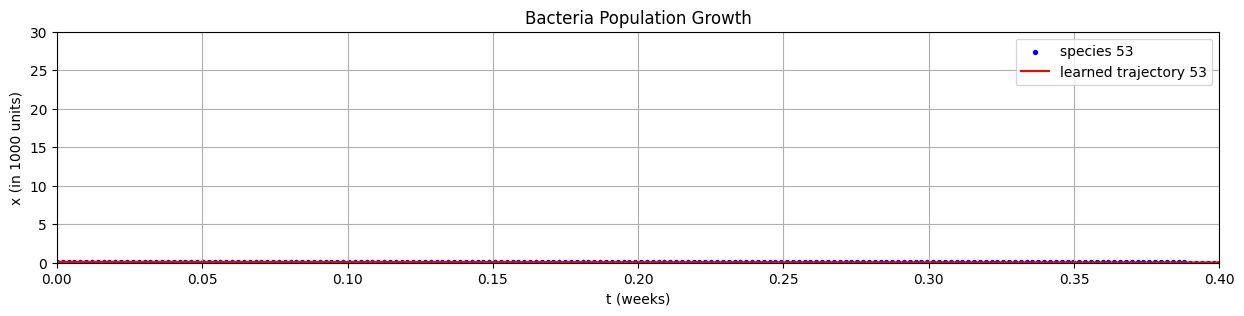

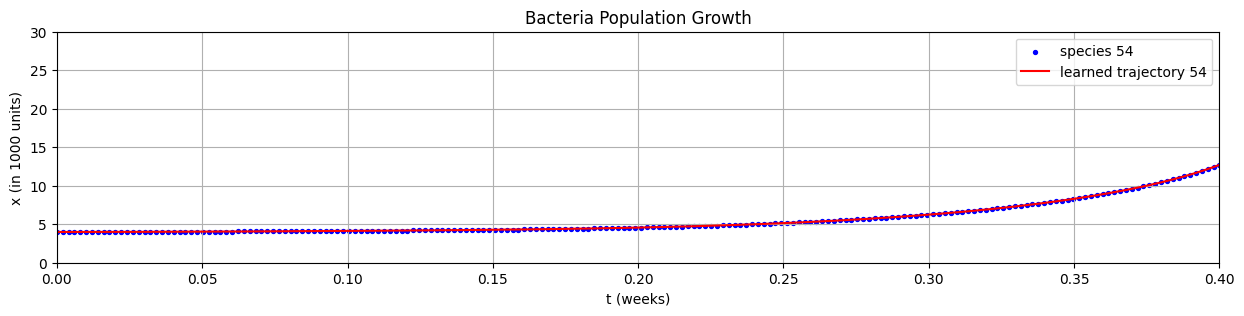

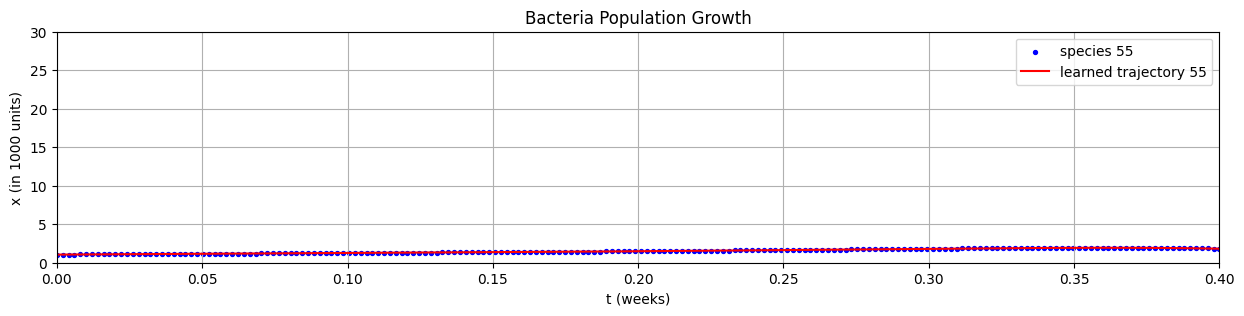

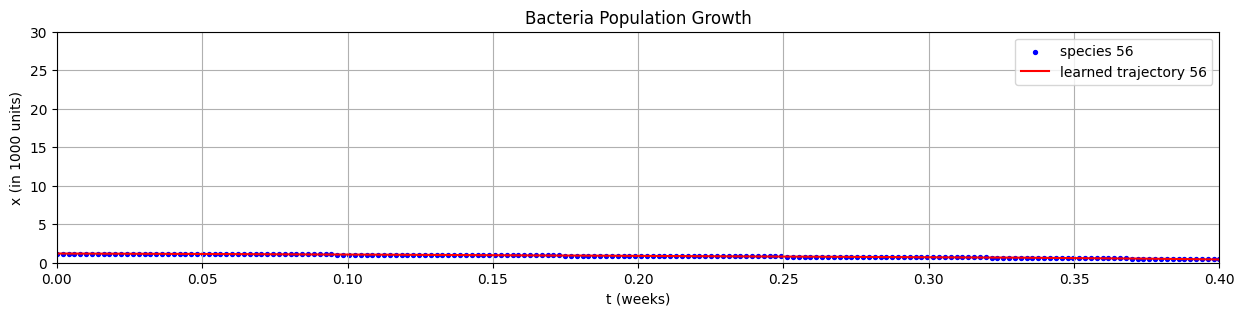

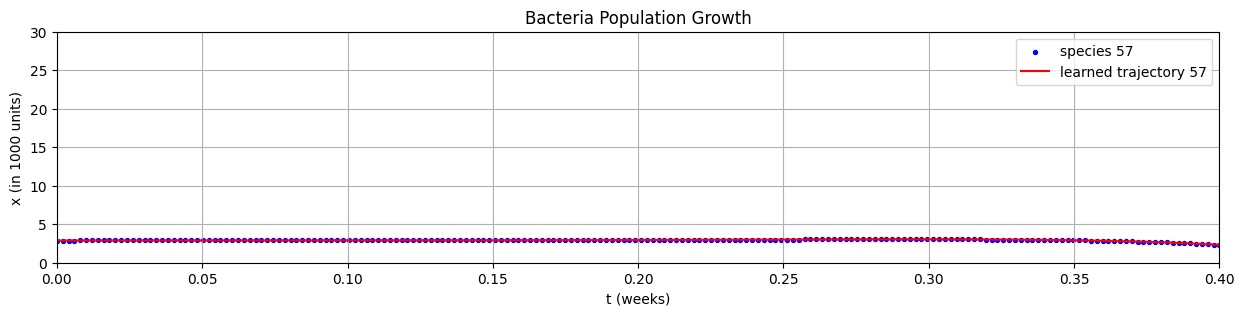

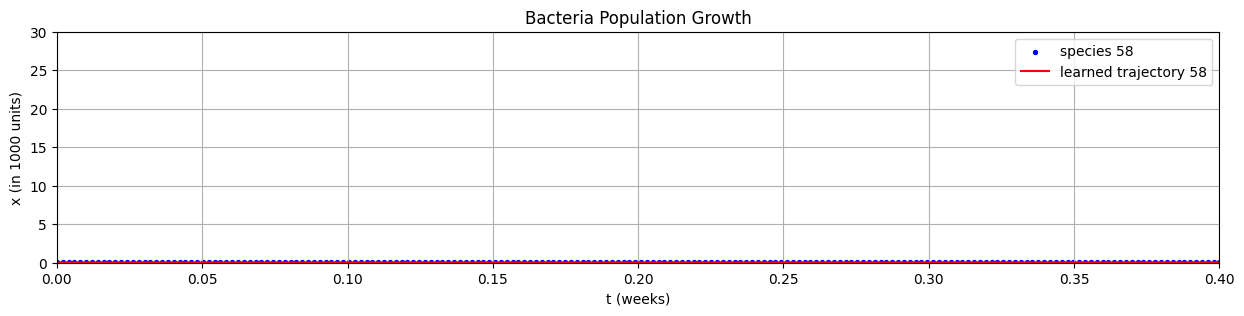

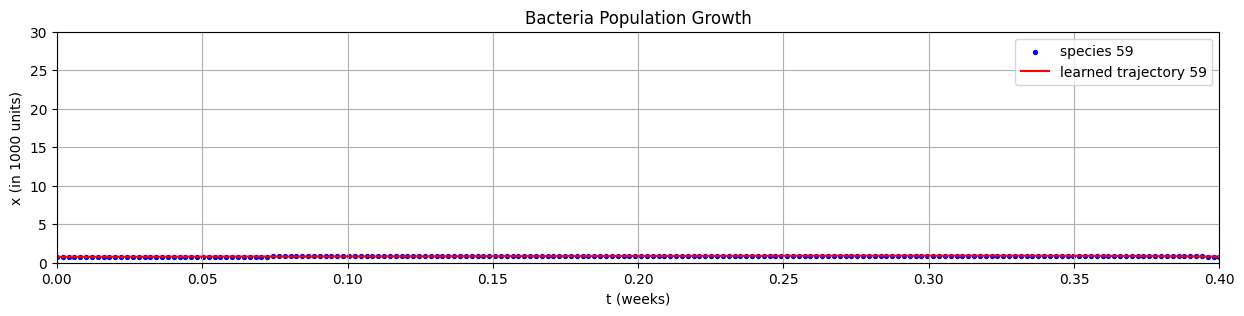

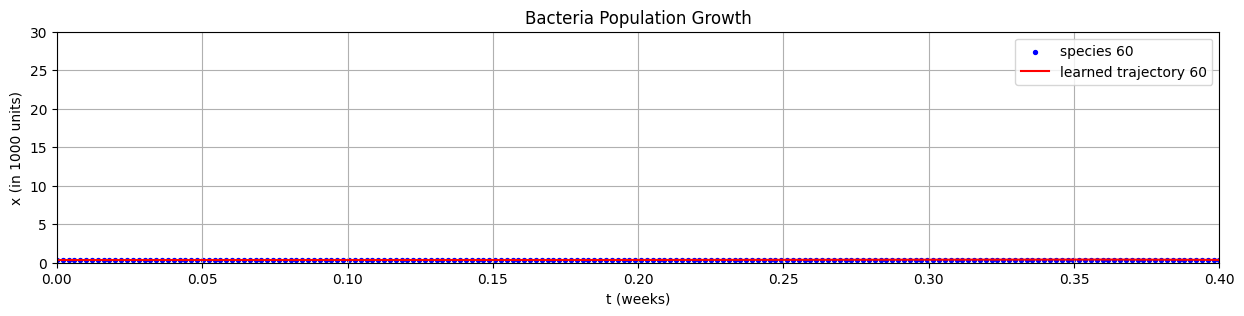

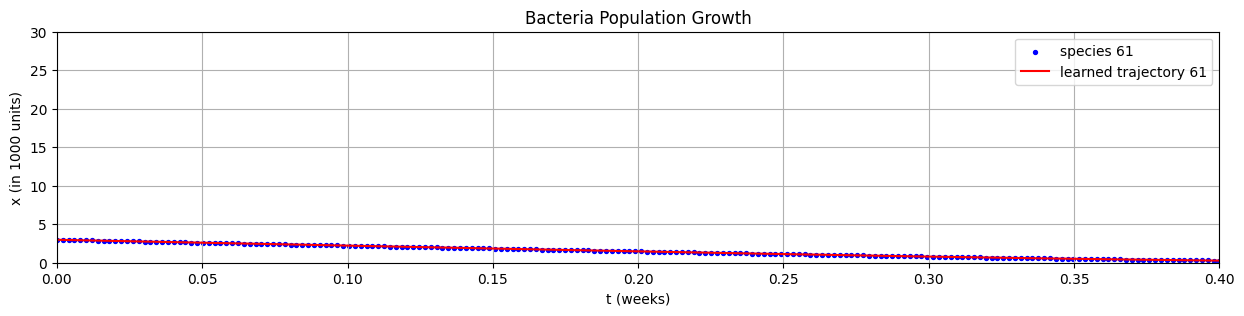

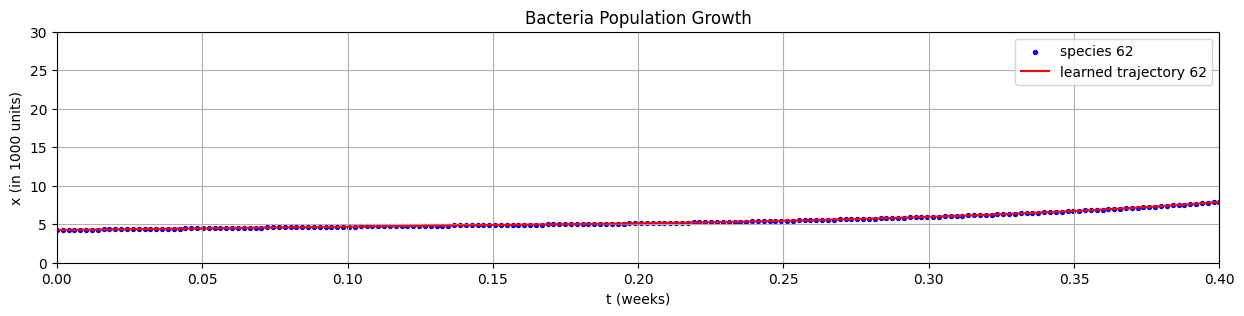

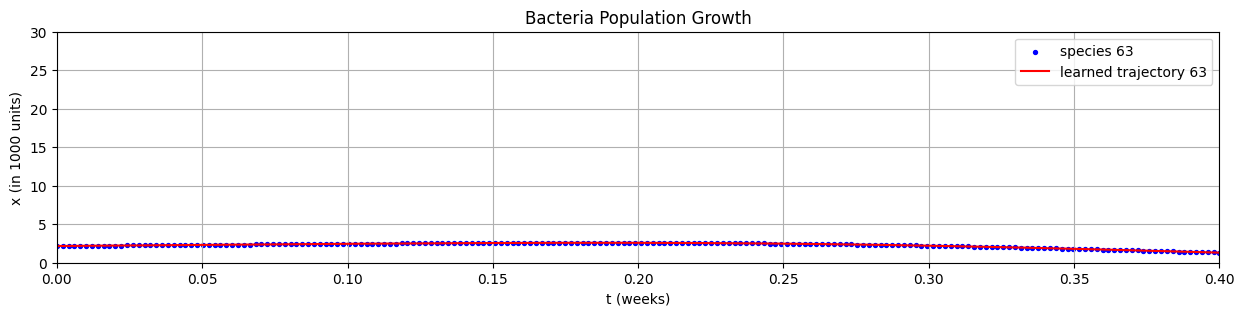

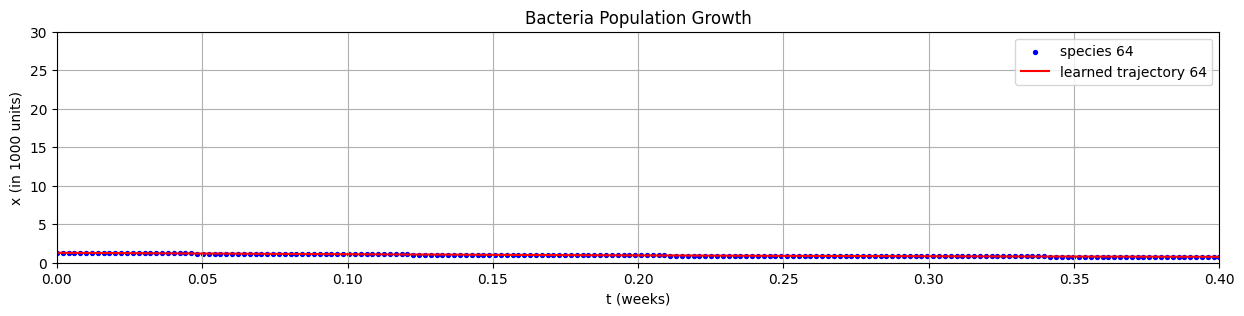

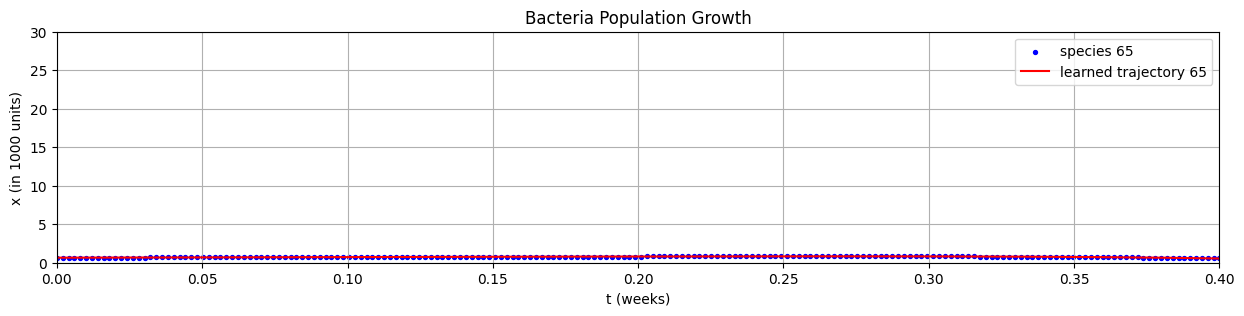

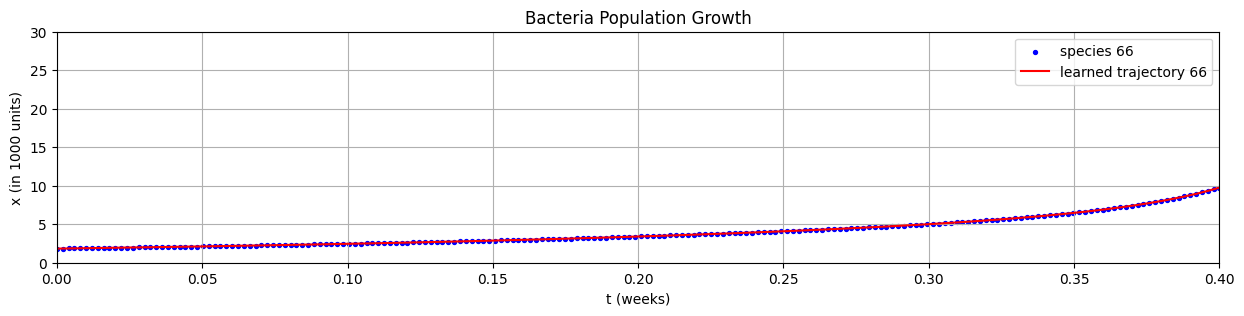

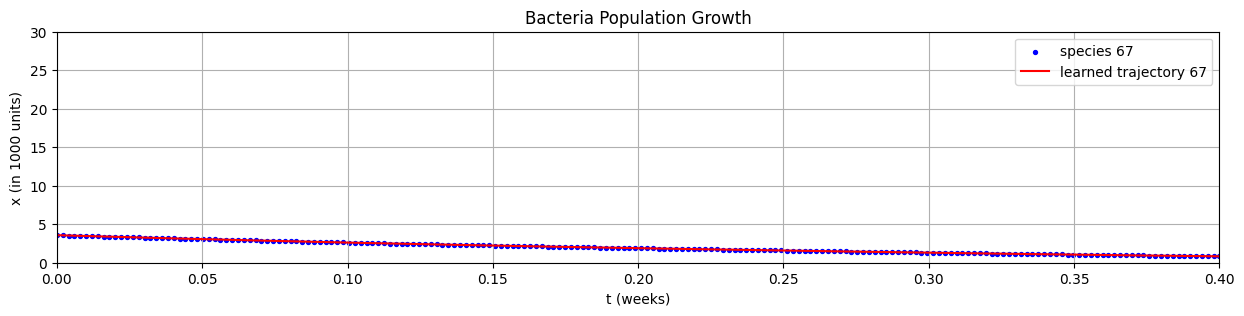

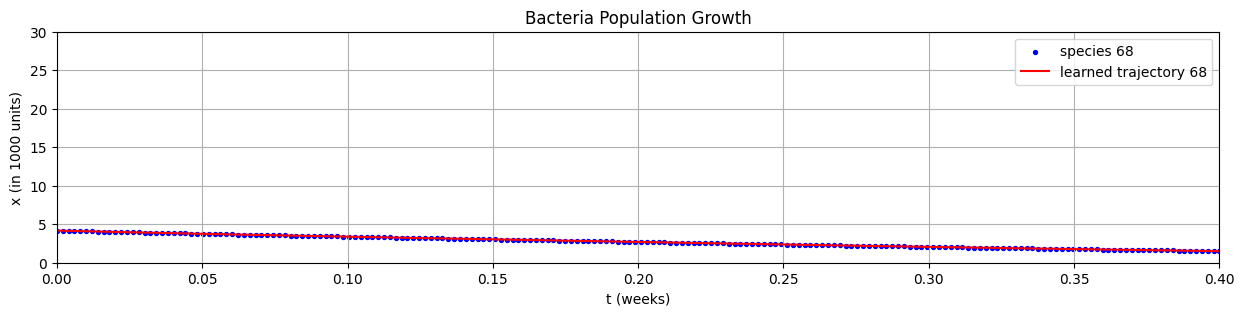

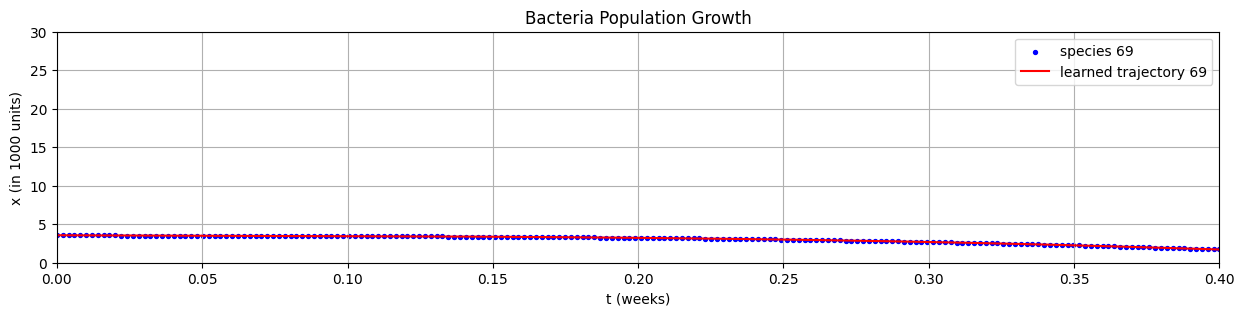

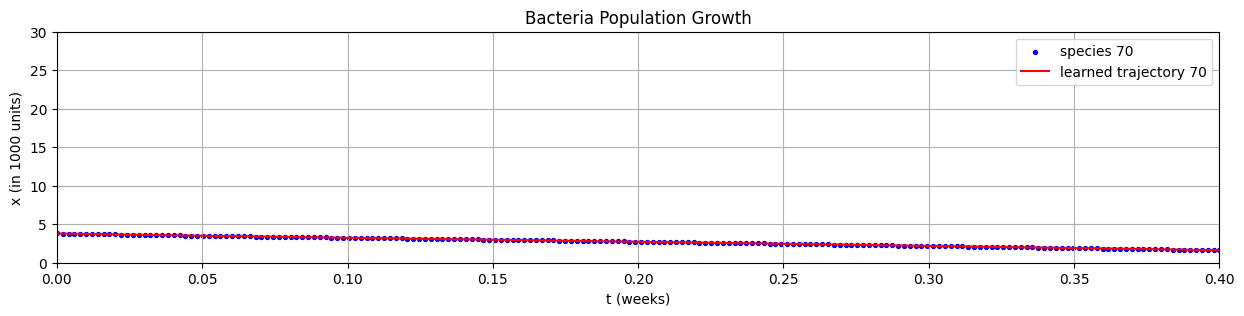

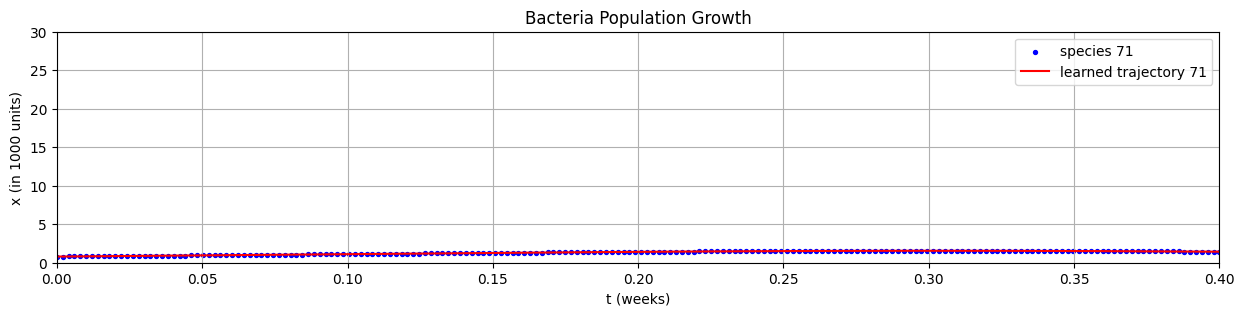

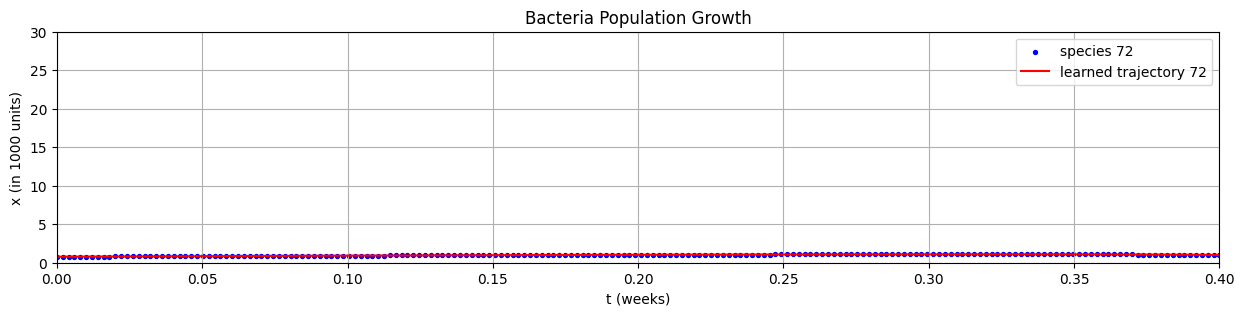

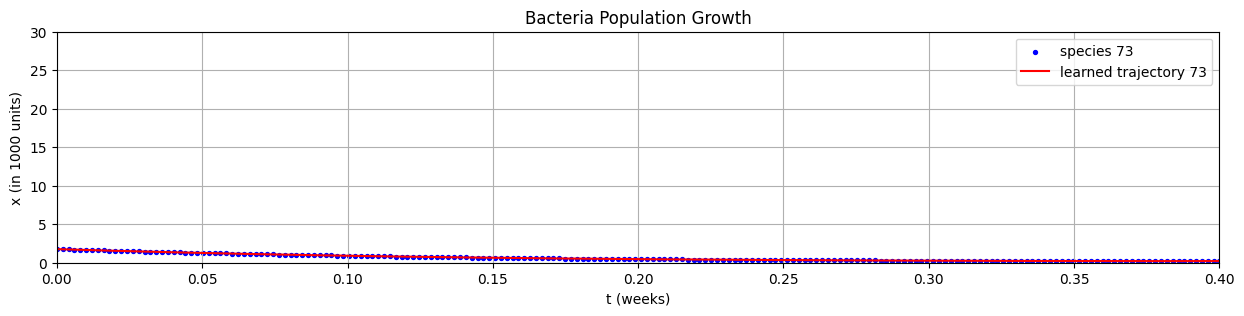

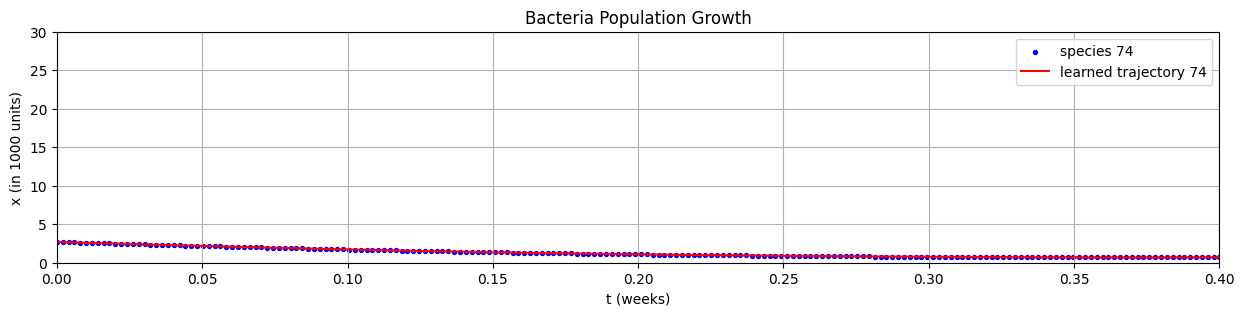

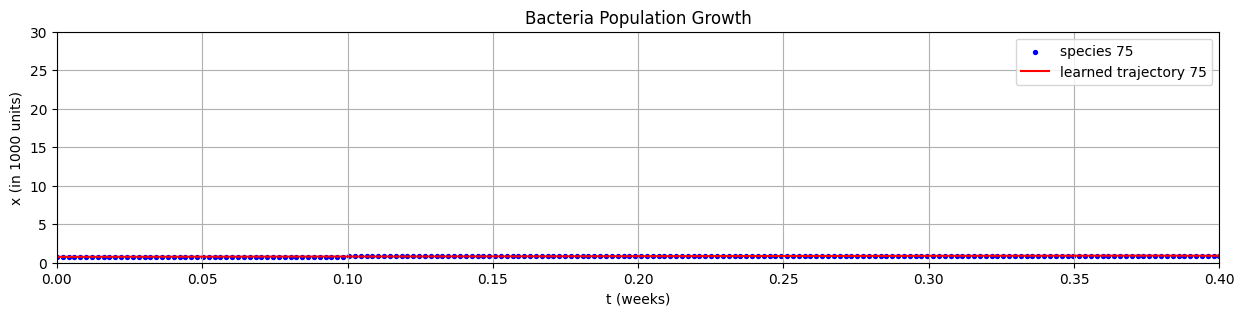

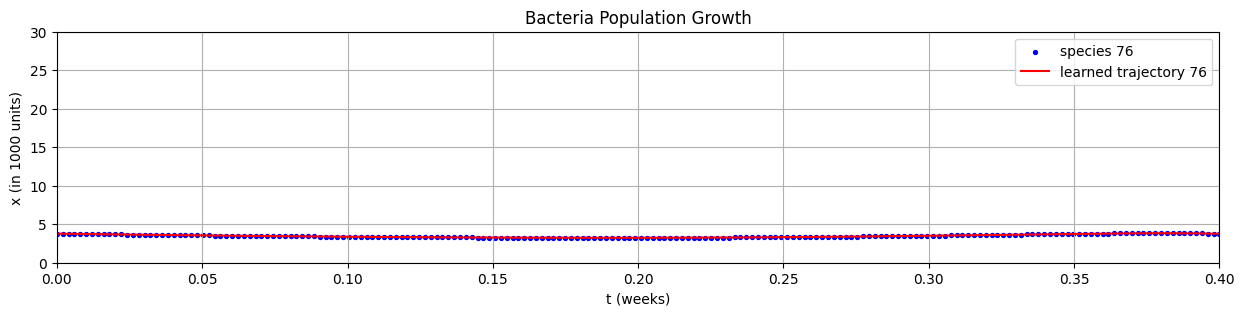

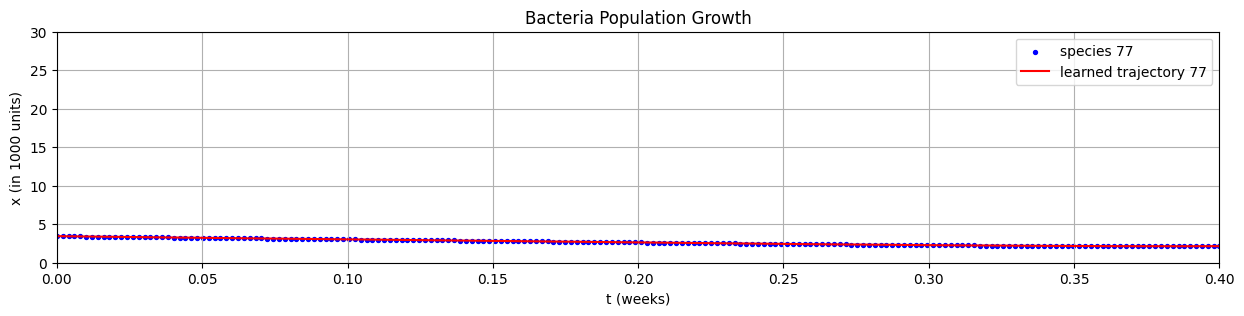

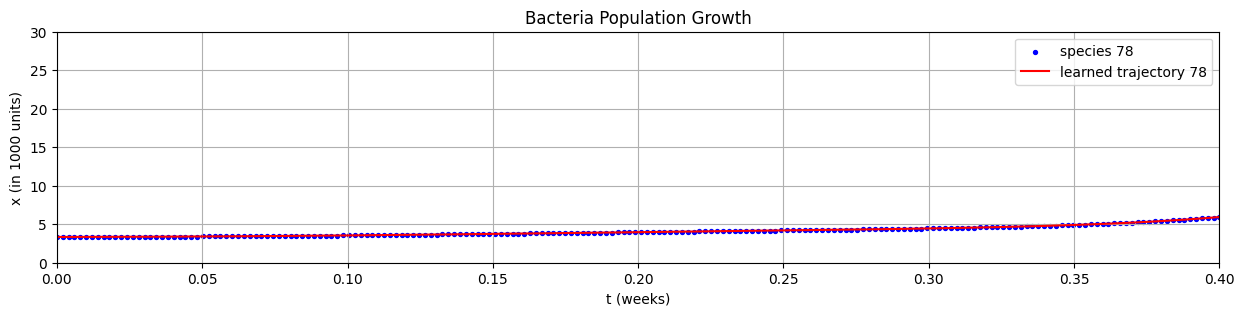

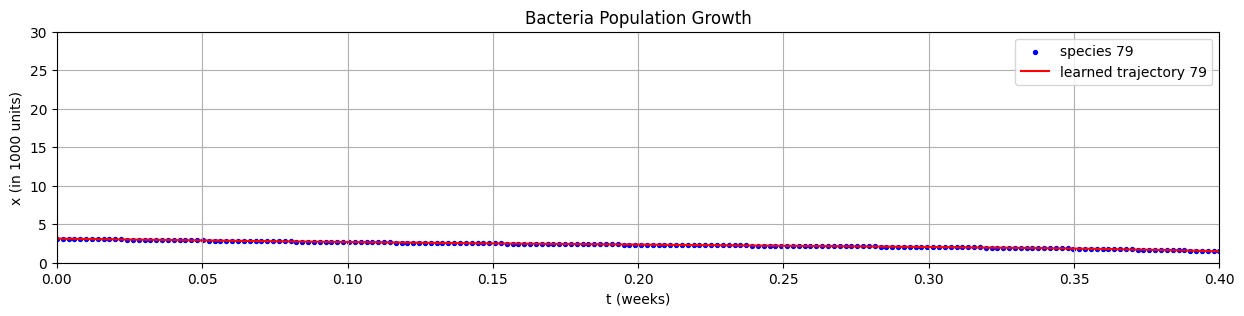

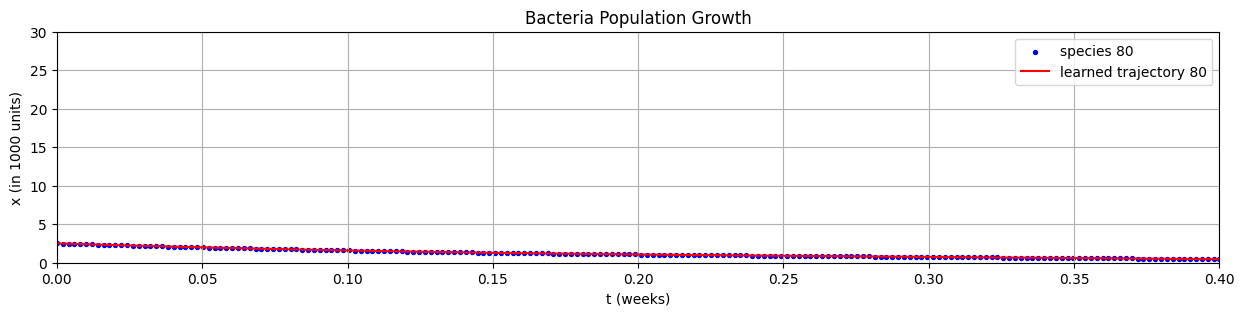

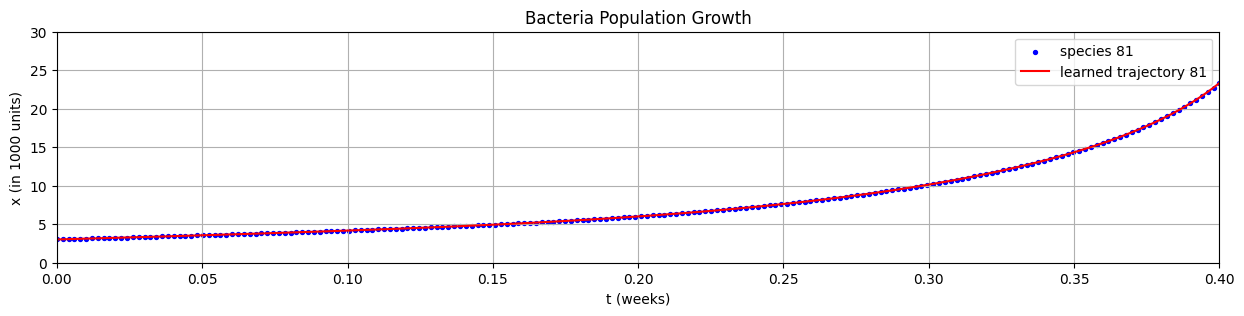

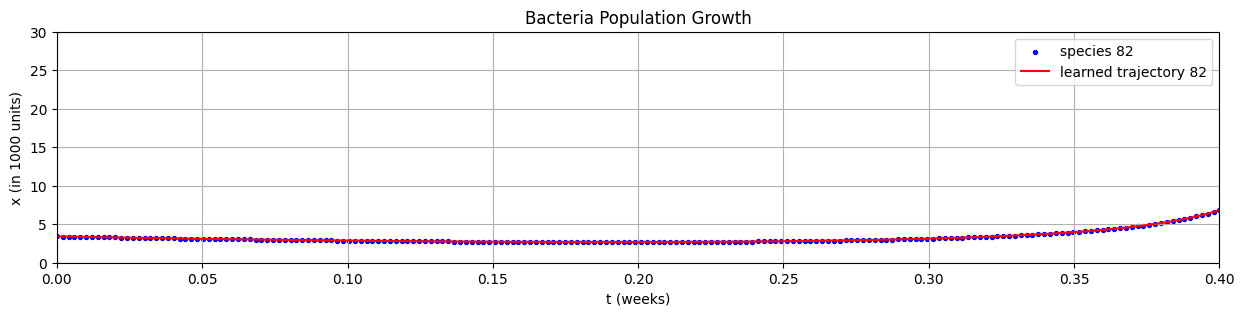

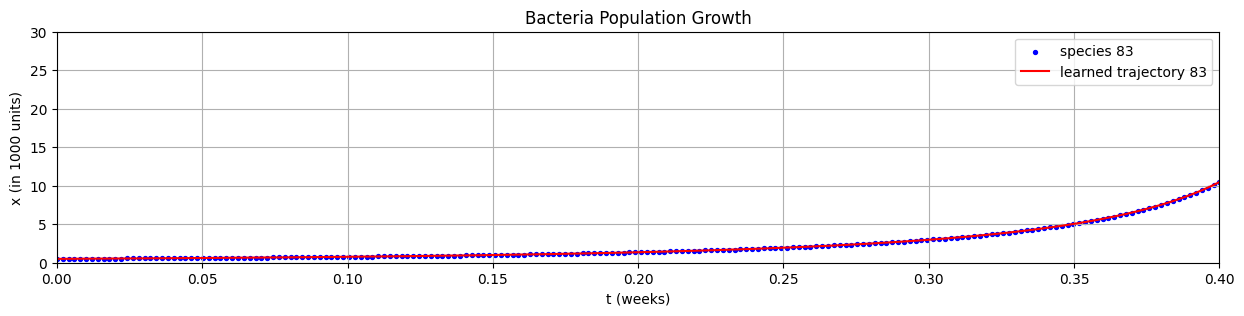

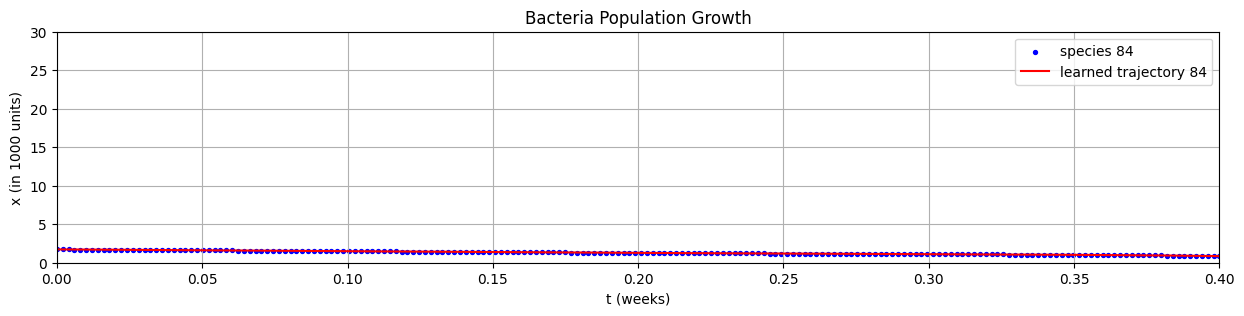

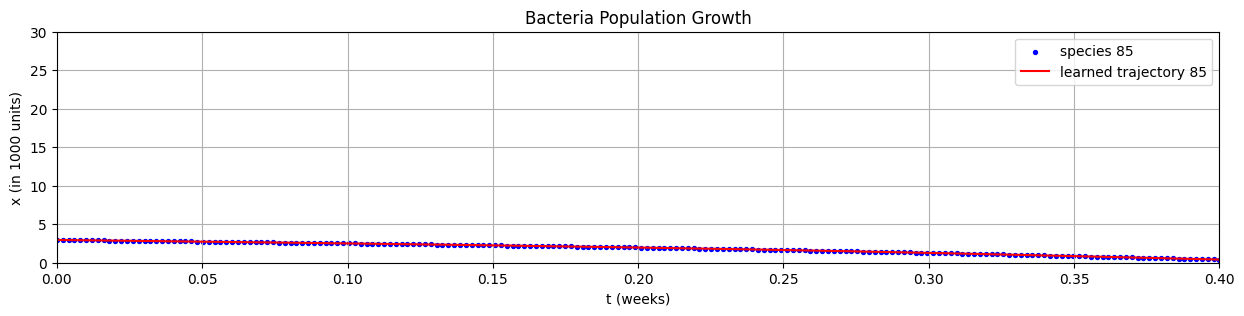

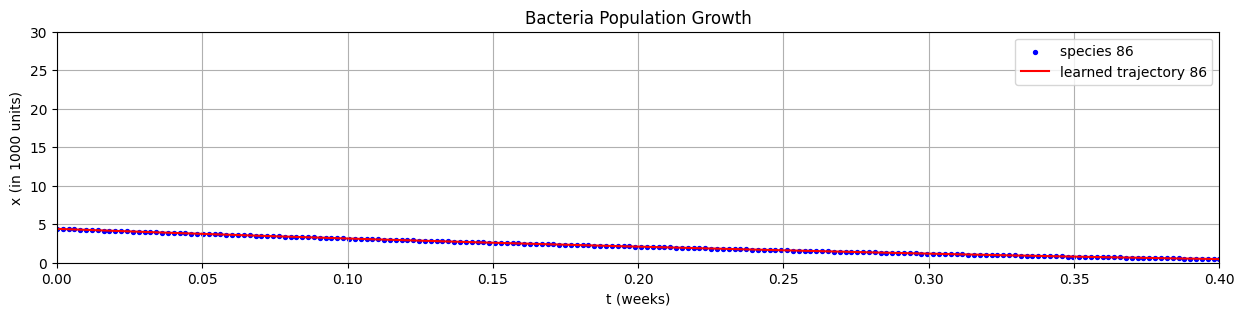

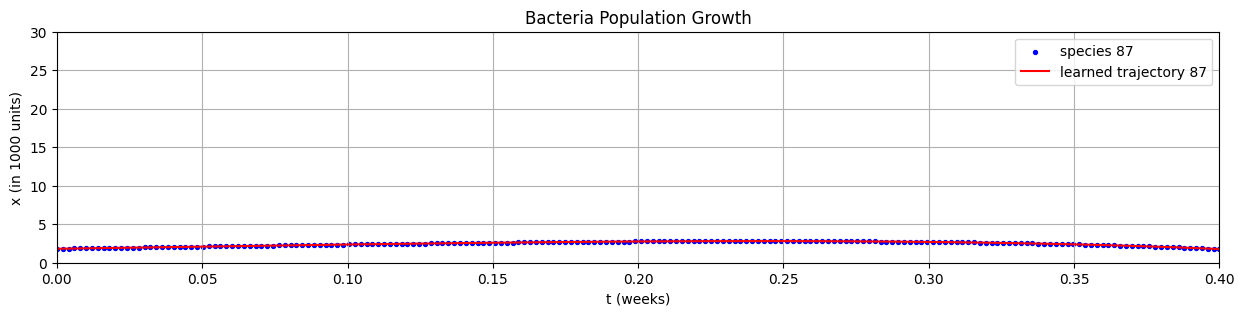

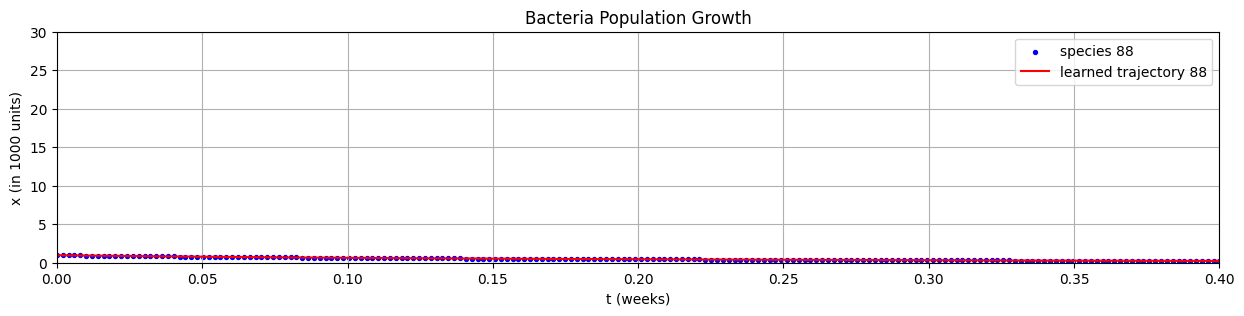

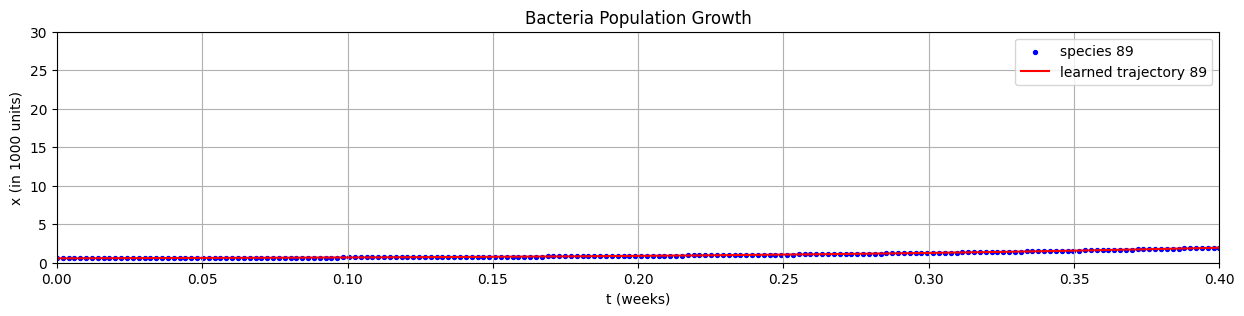

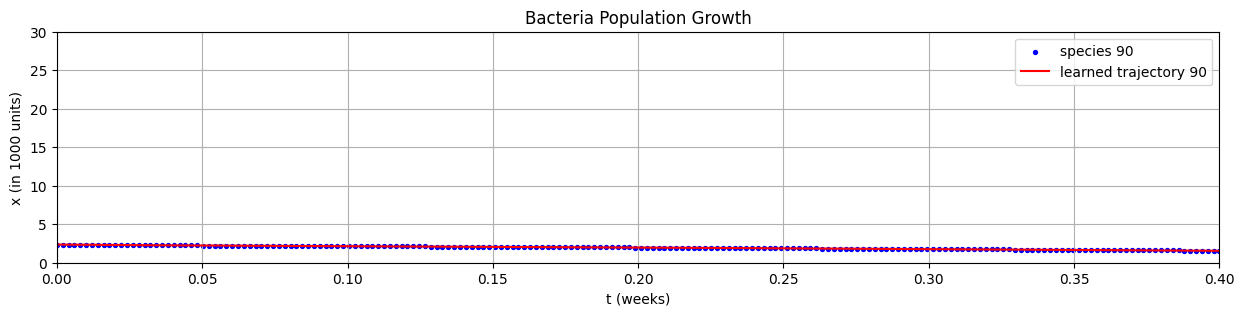

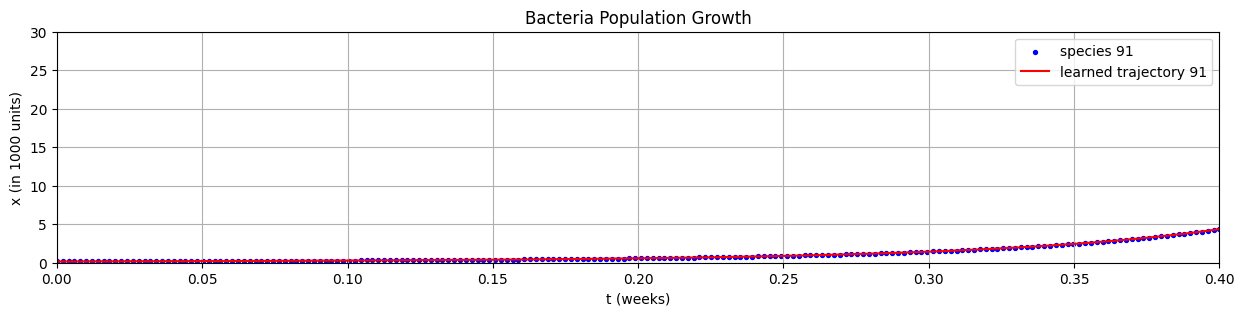

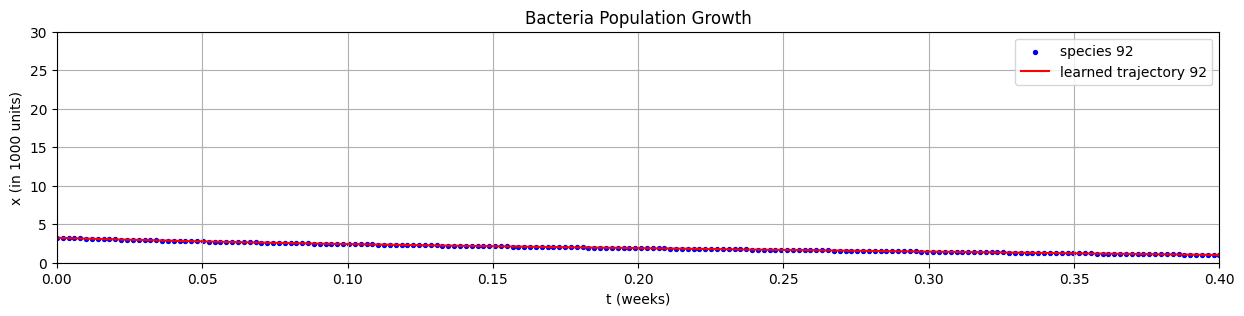

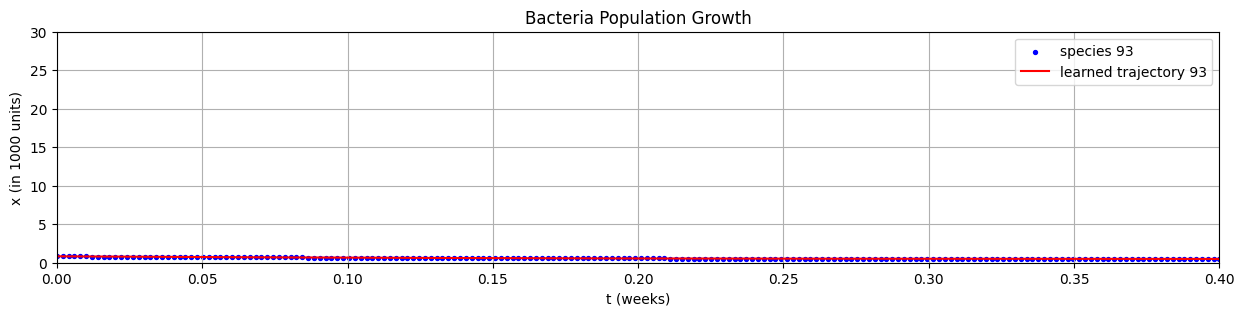

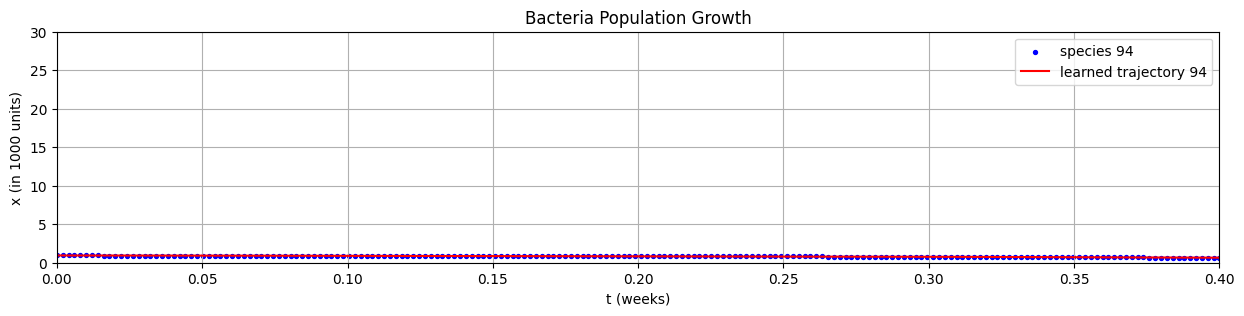

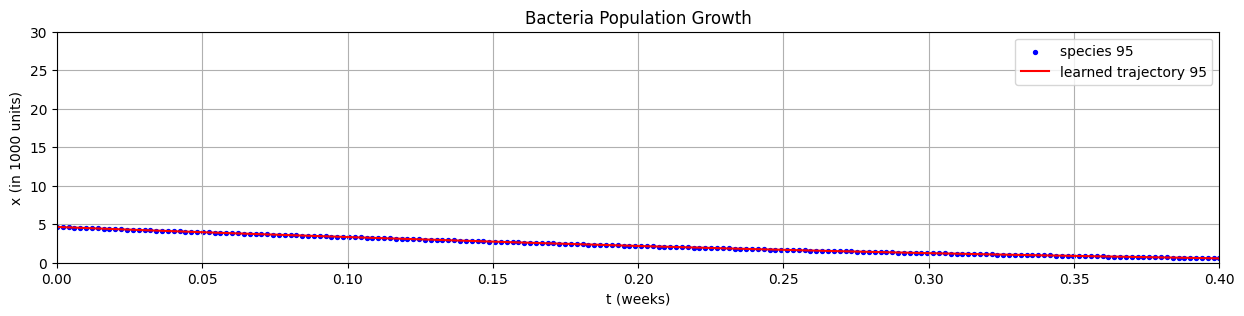

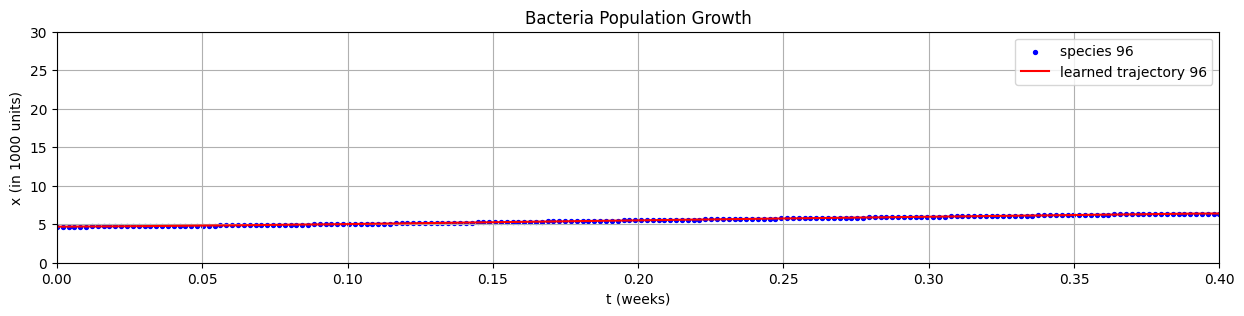

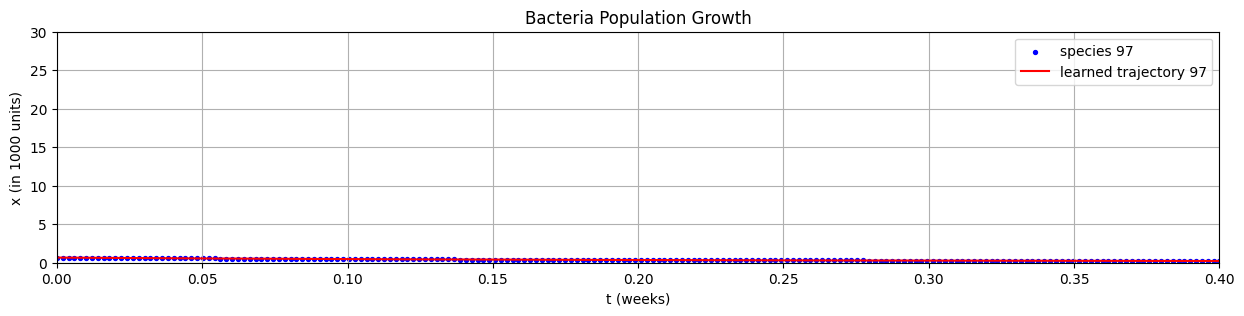

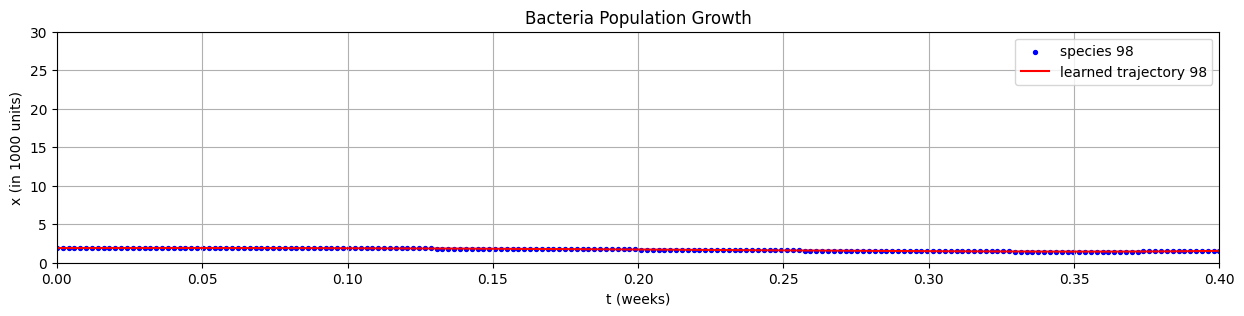

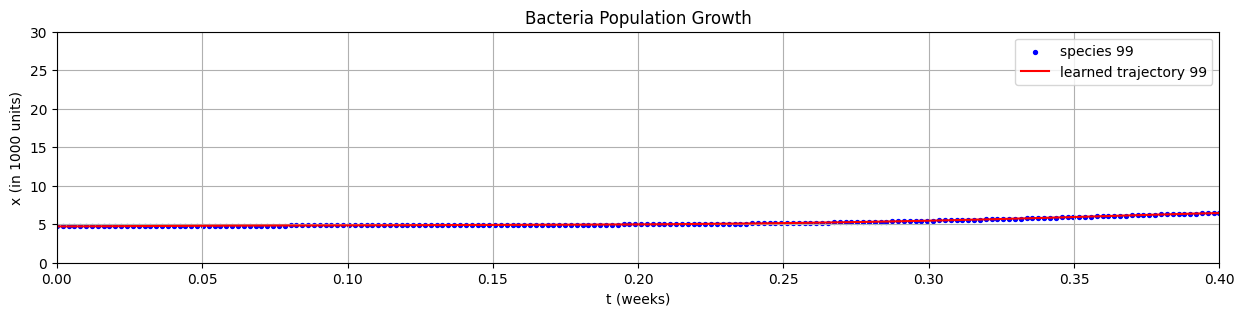

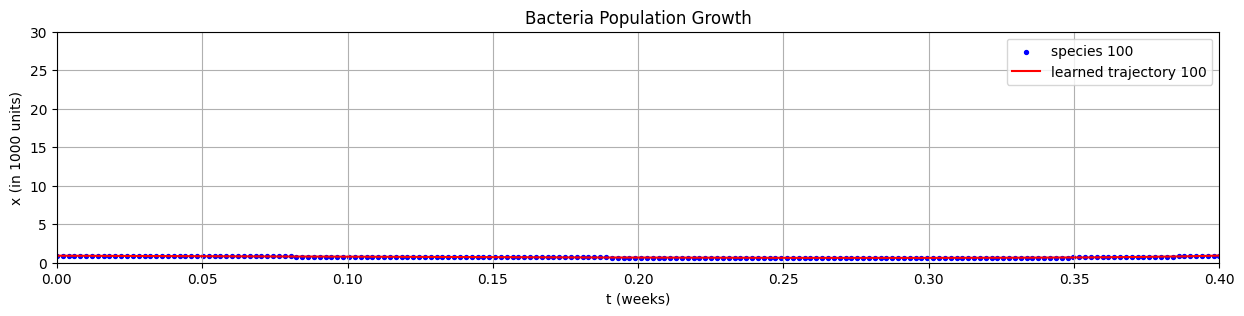

In [ ]:
for i in range(m):
  fig = plt.figure(figsize=(15, 3), facecolor='white')
  ax = fig.add_subplot(111)
  ax.set_title('Bacteria Population Growth')
  ax.set_xlabel('t (weeks)')
  ax.set_ylabel('x (in 1000 units)')
  ax.scatter(t, pred_y.cpu().numpy()[:, 0, i], color='blue', label='species '+str(i+1), s=8)
  ax.plot(t, pred_y.cpu().numpy()[:, 0, i], 'red', label='learned trajectory '+str(i+1))
  ax.set_xlim(0, T_end)
  ax.set_ylim(0, 30)
  plt.legend()
  plt.grid(True)
  plt.show()

Define a dictionary that contains:

1. Environmental variables
2. Model parameters
3. Species evolution trajectory

Get 20 such dictionary elements.

In [ ]:
# Set random seeds for reproducibility
def set_random_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)

set_random_seeds()

In [ ]:
# Parameters
n = 5    # Number of environmental variables
m = 100  # Number of species
T = 200  # Number of time points
T_end = 0.4
M = 20   # Number of iterations

In [ ]:
# Dictionary to store results
results = {}
total_nos = 0
while total_nos <= M:
    print("No of models: ", total_nos)
    t = torch.tensor(np.linspace(0, T_end, T))
    e = normalize_time_series(generate_env_time_series(n, T))
    e = torch.tensor(e, dtype=torch.float32)

    sim = NeuralODE(func=ODEFunc_sim(n, m))

    # Assign model weights
    nn.init.normal_(sim.func.net_1.weight, mean=0, std=0.1)
    nn.init.normal_(sim.func.net_1.bias, mean=0, std=0.1)
    nn.init.normal_(sim.func.net_2.weight, mean=0, std=0.1)
    nn.init.normal_(sim.func.net_3.B, mean=0, std=0.001)

    # Ensure diagonal elements of net_2 weight matrix are negative
    with torch.no_grad():
        for k in range(m):
            if sim.func.net_2.weight[k, k] > 0:
                sim.func.net_2.weight[k, k] = -sim.func.net_2.weight[k, k]  # Ensure it's negative

    x_0 = torch.rand(m) * 5

    with torch.no_grad():
        pred_y = sim(x_0.unsqueeze(0), e.transpose(0, 1).unsqueeze(1), t, solver=euler)

        # Check for NaN values in predictions
        if not torch.isnan(pred_y).any() and torch.max(pred_y) < 30.0 and torch.min(pred_y) > 0.0:

            total_nos += 1
            results[total_nos] = {
                'weight_net_1': sim.func.net_1.weight.detach().clone(),
                'bias_net_1': sim.func.net_1.bias.detach().clone(),
                'weight_net_2': sim.func.net_2.weight.detach().clone(),
                'e': e.clone(),
                'pred_y': pred_y.clone(),
                't': t.clone()
            }

    if total_nos == M:
        break

No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  0
No of models:  1
No of models:  2
No of models:  2
No of models:  2
No of models:  2
No of models:  2
No of models:  2
No of models:  2
No of models:  2
No of models:  2
No of models:  2
No of models:  2
No of models:  2
No of models:  3
No of models:  3
No of models:  3
No of models:  3
No of models:  4
No of models:  4
No of models:  4
No of models:  4
No of models:  4
No of models:  4
No of models:  4
No of models:  4
No of models:  4
No of models:  5
No of models:  6
No of models:  6
No of models:  6
No of models:  6
No of models:  6
No of models:  6
No of models:  6
No of models:  6
No of models: 

In [ ]:
total_nos

20

In [ ]:
results.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [ ]:
import pickle

# Save the dictionary to a file
with open('results_simulation.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Dictionary saved to 'results_simulation.pkl'")

Dictionary saved to 'results_simulation.pkl'
